# <span style = "font-weight:bold;">Cohort, RFM 이커머스</span>
> <span style = "font-weight:bold;font-size:1.3em">목차</span>
>1. 사용 라이브러리
>2. 데이터 전처리 탐색 및 전처리
>3. Cohort 분석
>4. RFM 분석
>5. RFM 군집 나누기
>6. 지역별 차트 작성, 어디가 주목할 지역인가?
>7. 장바구니 분석
>8. 기타 분석

> <span style = "font-weight:bold;font-size:1.3em">사용 데이터</span>
>- Onlinesales_info.csv : 온라인거래와 관련된 정보
>- Customer_info.csv : 고객과 관련된 정보
>- Discount_info.csv : 할인과 관련된 정보
>- Marketing_info.csv : 마케팅비용과 관련된 정보
>- Tax_info.csv : 세금과 관련된 정보

> <span style = "font-weight:bold;font-size:1.3em">분석 요약</span>

## <span style = "">1. 사용 라이브러리</span>
><span style="font-style:italic; font-weight:bold;">기본</span>
> - pandas
> - numpy
> - maplotlib
> - seaborn
> - datetime
> - scipy

> <span style="font-weight:bold;font-style:italic;">Machine Learning</span>
> - KMeans

><span style="font-weight:bold;font-style:italic;">선택사항</span>
>- warnings

><span style="font-weight:bold;font-style:italic;">장바구니 분석</span>
>- apriori
>- association_rules
>-  TransactionEncoder

In [1]:
# 분석에 사용될 기본 라이브러리들을 호출
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import scipy.stats as sp

from sklearn.cluster import KMeans
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

import matplotlib.pyplot as plt
plt.rc('font', family = 'Malgun Gothic')
plt.rcParams['font.family']
plt.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings(action='ignore')

import os
display(os.getcwd())
display(os.listdir())

'C:\\Users\\meo47\\OneDrive\\프로젝트\\공모전_데이콘_RFM_이커머스\\cohort_RFM_local'

['.git',
 '.ipynb_checkpoints',
 'cohort_RFM_final.ipynb',
 'cohort_RFM_ver4.ipynb',
 'cohort_RFM_ver5 (2).zip',
 'cohort_RFM_ver5 (3).zip',
 'cohort_RFM_ver5.ipynb',
 'cohort_RFM_ver5.zip',
 'preprocessing',
 'README.md']

## 2. 데이터 전처리
><span style="font-weight:bold; font-style:italic;">순서</span>

>(1) 데이터 불러오기

>(2) 데이터 결합
>- "Onlinesales_info.csv", "Customer_info.csv" <고객ID> 기준 merge
>- "Tax_info.csv" <제품카테고리> 기준 추가 merge
>- merge 과정에서 결측치 발생, 컬럼의 변화 여부 확인

>(3) Feature Engineering
> - 총 거래금액 = 평균금액 * 수량( 1 + 세금 ) + 배송료

>(4) CSV 저장
>- "total_information.csv"

In [2]:
# (1) 데이터 확인
Onlinesales_info = pd.read_csv('../origin/Onlinesales_info.csv')
Customer_info = pd.read_csv('../origin/Customer_info.csv')
Tax_info = pd.read_csv('../origin/Tax_info.csv')
Marketing_info = pd.read_csv('../origin/Marketing_info.csv')
Discount_info = pd.read_csv('../origin/Discount_info.csv')

In [3]:
# (2) 데이터 결합
# Online_sales_info.csv, Customer_info.csv, Tax_info.csv 파일들을 결합한다.
first_merge = pd.merge(Onlinesales_info, Customer_info, on = '고객ID', how = 'outer')
total_information = pd.merge(first_merge, Tax_info, on = '제품카테고리', how = 'outer')

In [4]:
# merge 과정에서 컬럼의 누락 등이 발생했는지 확인
def col_list(target, feature): 
    for i in list(feature.columns): # for문을 돌면서 feature를 담고, 중복 요소는 list(set())으로 제거
        target.append(i)
    target_list = list(set(target))
    return target_list

def check_col(list1, list2): # 비교하기 전에 정렬 수행
    list1.sort()
    list2.sort()
    print(list1==list2)
    
check_list = []
check_list = col_list(check_list, Onlinesales_info)
check_list = col_list(check_list, Customer_info)
check_list = col_list(check_list, Tax_info)

check_col(check_list, list(total_information.columns))

True


In [5]:
# 평균금액, 수량, 세금, 배송료 정보를 활용하여 새로운 컬럼인 "Total_Purchase_Amount"를 정의한다.
# (3) Feature Engineering
total_information['Total_Purchase_Amount'] = total_information['평균금액']*total_information['수량']*(1+total_information['GST'])+ total_information['배송료']

# (4) CSV 저장
total_information.to_csv('./preprocessing/total_information.csv', index=False)
total_information = pd.read_csv('./preprocessing/total_information.csv')
display(total_information, total_information.isnull().sum(), total_information.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52924 entries, 0 to 52923
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   고객ID                   52924 non-null  object 
 1   거래ID                   52924 non-null  object 
 2   거래날짜                   52924 non-null  object 
 3   제품ID                   52924 non-null  object 
 4   제품카테고리                 52924 non-null  object 
 5   수량                     52924 non-null  int64  
 6   평균금액                   52924 non-null  float64
 7   배송료                    52924 non-null  float64
 8   쿠폰상태                   52924 non-null  object 
 9   성별                     52924 non-null  object 
 10  고객지역                   52924 non-null  object 
 11  가입기간                   52924 non-null  int64  
 12  GST                    52924 non-null  float64
 13  Total_Purchase_Amount  52924 non-null  float64
dtypes: float64(4), int64(2), object(8)
memory usage: 5.7+ 

,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,성별,고객지역,가입기간,GST,Total_Purchase_Amount
0,USER_1358,Transaction_0000,2019-01-01,Product_0981,Nest-USA,1,153.71,6.50,Used,남,Chicago,12,0.10,175.5810
1,USER_1358,Transaction_0001,2019-01-01,Product_0981,Nest-USA,1,153.71,6.50,Used,남,Chicago,12,0.10,175.5810
2,USER_1358,Transaction_0013,2019-01-01,Product_0983,Nest-USA,2,122.77,6.50,Not Used,남,Chicago,12,0.10,276.5940
3,USER_1358,Transaction_0015,2019-01-01,Product_0984,Nest-USA,1,81.50,6.50,Clicked,남,Chicago,12,0.10,96.1500
4,USER_1358,Transaction_0016,2019-01-01,Product_0981,Nest-USA,1,153.71,6.50,Clicked,남,Chicago,12,0.10,175.5810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52919,USER_0442,Transaction_7918,2019-05-04,Product_0850,More Bags,5,17.59,18.12,Clicked,여,California,13,0.18,121.9010
52920,USER_0557,Transaction_7940,2019-05-04,Product_0850,More Bags,1,17.59,6.00,Not Used,남,California,36,0.18,26.7562
52921,USER_1374,Transaction_8818,2019-05-19,Product_0850,More Bags,1,21.99,6.00,Used,여,Chicago,27,0.18,31.9482
52922,USER_0994,Transaction_9049,2019-05-22,Product_0850,More Bags,1,17.59,51.99,Used,여,New York,46,0.18,72.7462


고객ID                     0
거래ID                     0
거래날짜                     0
제품ID                     0
제품카테고리                   0
수량                       0
평균금액                     0
배송료                      0
쿠폰상태                     0
성별                       0
고객지역                     0
가입기간                     0
GST                      0
Total_Purchase_Amount    0
dtype: int64

None

## 3. Cohort 분석
><span style="font-weight:bold; font-style:italic;">순서</span>

> (1) CSV 생성
> - cohort.csv(=단위 군집에 대한 고객 숫자, 거래 금액 정보)
> - is_back(=단위 군집의 재방문율 변화)
> - co_purchase(=단위 군집의 총거래금액 변화)

>(2) 클래스 및 함수 정의

>(3) Cohort 그래프 분석
> - is_back 그래프 분석
> - co_purchase 그래프 분석

>(4) 코호트 군집 분석, Feature Engineering
> - < is_back_up_down 컬럼 > cohort 단위 군집의 "직전 월 대비 재방문율 증가 횟수" - "직전 월 대비 재방문율 감소 횟수"
> - < co_purchase_up_down 컬럼 > cohort 단위 군집의 "직전 월 대비 총거래금액 증가 횟수" - "직전 월 대비 총거래금액 감소 횟수"

> (5) 분석 - 마케팅 비용과 코호트 군집 간의 상관관계 분석

## (1) Cohort CSV 생성

In [6]:
# 고객을 월단위로 묶어 재방문율의 변화, 거래금액의 변화를 분석한다.
def First_OrderMonth(df, ref_month, customer_col): # 첫 주문월과 구매 주기 컬럼 추가
    df[ref_month] = pd.to_datetime(df[ref_month])
    df['OrderCycle'] = df[ref_month].dt.strftime('%Y-%m') # 구매 주기를 계산하기 위한 OrderCycle 추가
    first_order = df.groupby(customer_col)[ref_month].min() # 첫 구매 주기를 구하기 위해 .min() 사용
    first_order = first_order.dt.strftime('%Y-%m') # 형식 년,월로 변경
    df.set_index(customer_col, inplace = True)
    df['First_Order'] = first_order
    df.reset_index(inplace=True)
    return df

def CohortPeriod(df, first_order, order_cycle): # 코호트 주기 계산
    temp = []
    for i in range(df.shape[0]):
        f_first_order = pd.to_datetime(df[first_order][i]).to_period('M')
        f_order_cycle = pd.to_datetime(df[order_cycle][i]).to_period('M')
        month_diff = (f_order_cycle-f_first_order).n # order_cycle과 first_order(첫 구매월)의 차이를 계산하여 Cohort 주기 계산
        temp.append(month_diff)
    df['CohortPeriod'] = temp # 데이터프레임에 CohortPeriod 열 추가, 정수 데이터
    return df

def CohrotFrame(df, first_order, cohort_period, target_col, ratio=None): # pandas unstack 진행
    df = df.set_index([first_order, cohort_period]) # 인덱스로 사용할 컬럼 지정
    df = df[target_col].unstack(1)
    if ratio is not None: # ratio를 구할지 말지 선택지를 함수를 호출할 때 결정
        df = df.div(df[0], axis=0) # 첫 월 대비 몇 프로의 비율이 남아있는지 확인하기 위한 과정이다.
    return df

## cohort를 위해 기존 파일 전처리, CSV 저장

In [7]:
# 불필요한 컬럼들을 제거한다.
cohort = total_information.drop([ '수량', '제품카테고리', '평균금액', '배송료', 
                                 '쿠폰상태', '성별', '고객지역', '가입기간', 'GST'], axis=1)

cohort = First_OrderMonth(cohort, '거래날짜', '고객ID')
# 예시) 첫 주문월이 1월인 고객 중에서 2월에 다시 방문한 고객의 숫자, 첫 주문월에 X원만큼 쓴 고객이 2월에 쓴 금액
co1= cohort.groupby(['First_Order', 'OrderCycle'])['고객ID'].nunique()
co1 = co1.reset_index()
co2 = cohort.groupby(['First_Order', 'OrderCycle'])['Total_Purchase_Amount'].sum()
co2 = co2.reset_index()

co = pd.merge(co1, co2, on = ['First_Order', 'OrderCycle'])

co = CohortPeriod(co, 'First_Order', 'OrderCycle') # 코호트 주기 계산
co.rename({'고객ID':'TotalUsers'}, axis = 1,inplace=True)

co.to_csv('./preprocessing/cohort.csv', index=False) # 코호트 csv 저장
co = pd.read_csv('./preprocessing/cohort.csv')
# display(co, co.isnull().sum(), co.info())

## Cohort 데이터프레임 생성

In [8]:
is_back = CohrotFrame(co, 'First_Order', 'CohortPeriod', 'TotalUsers', ratio = True)
co_purchase= CohrotFrame(co, 'First_Order', 'CohortPeriod', 'Total_Purchase_Amount', ratio = None)
is_back.to_csv('./preprocessing/is_back.csv', index=False)
co_purchase.to_csv('./preprocessing/co_purchase.csv', index=False)
is_back, co_purchase = pd.read_csv('./preprocessing/is_back.csv'), pd.read_csv('./preprocessing/co_purchase.csv')
display(is_back, co_purchase)

,0,1,2,3,4,5,6,7,8,9,10,11
0,1.0,0.060465,0.111628,0.158140,0.106977,0.204651,0.162791,0.218605,0.106977,0.130233,0.093023,0.15814
1,1.0,0.072917,0.093750,0.166667,0.177083,0.229167,0.197917,0.156250,0.125000,0.114583,0.166667,NaN
2,1.0,0.101695,0.197740,0.141243,0.180791,0.186441,0.124294,0.124294,0.084746,0.107345,NaN,NaN
3,1.0,0.085890,0.147239,0.147239,0.110429,0.092025,0.061350,0.098160,0.073620,NaN,NaN,NaN
4,1.0,0.107143,0.080357,0.116071,0.089286,0.116071,0.125000,0.071429,NaN,NaN,NaN,NaN
5,1.0,0.145985,0.160584,0.087591,0.080292,0.102190,0.080292,NaN,NaN,NaN,NaN,NaN
6,1.0,0.138298,0.042553,0.063830,0.117021,0.095745,NaN,NaN,NaN,NaN,NaN,NaN
7,1.0,0.103704,0.111111,0.074074,0.059259,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1.0,0.076923,0.038462,0.025641,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1.0,0.068966,0.045977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,0,1,2,3,4,5,6,7,8,9,10,11
0,508514.7551,49784.6856,64142.5787,136619.1519,37938.0847,64941.1638,103192.3727,63845.5539,50049.6573,54859.6360,46675.3220,108822.663
1,347080.9714,10790.6607,15816.3338,27845.3921,29272.5815,52488.0460,30126.2571,54556.0959,20170.3275,33249.6095,55215.2866,NaN
2,378271.8279,49417.8369,45043.3898,37257.0493,57979.0999,84903.4851,58303.3383,47338.3423,28720.4471,42783.4613,NaN,NaN
3,290706.3843,28735.0564,20328.1163,36830.3649,31477.7593,36086.3232,18730.5268,64759.7279,21383.5292,NaN,NaN,NaN
4,247217.3724,8277.2382,15394.8251,18791.0656,20448.6132,44002.9696,43811.6734,13373.1959,NaN,NaN,NaN,NaN
5,236926.7848,13735.8622,16507.9096,19569.1335,12427.2960,43054.1566,18107.3596,NaN,NaN,NaN,NaN,NaN
6,185668.4481,18169.9318,8556.9241,17177.5039,27456.6556,33631.0107,NaN,NaN,NaN,NaN,NaN,NaN
7,243114.6476,12446.8954,13194.2294,33103.3770,19271.6494,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,180805.4449,2284.4464,2963.5980,768.4927,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,265442.4406,11231.6505,3295.4565,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Cohort 시각화

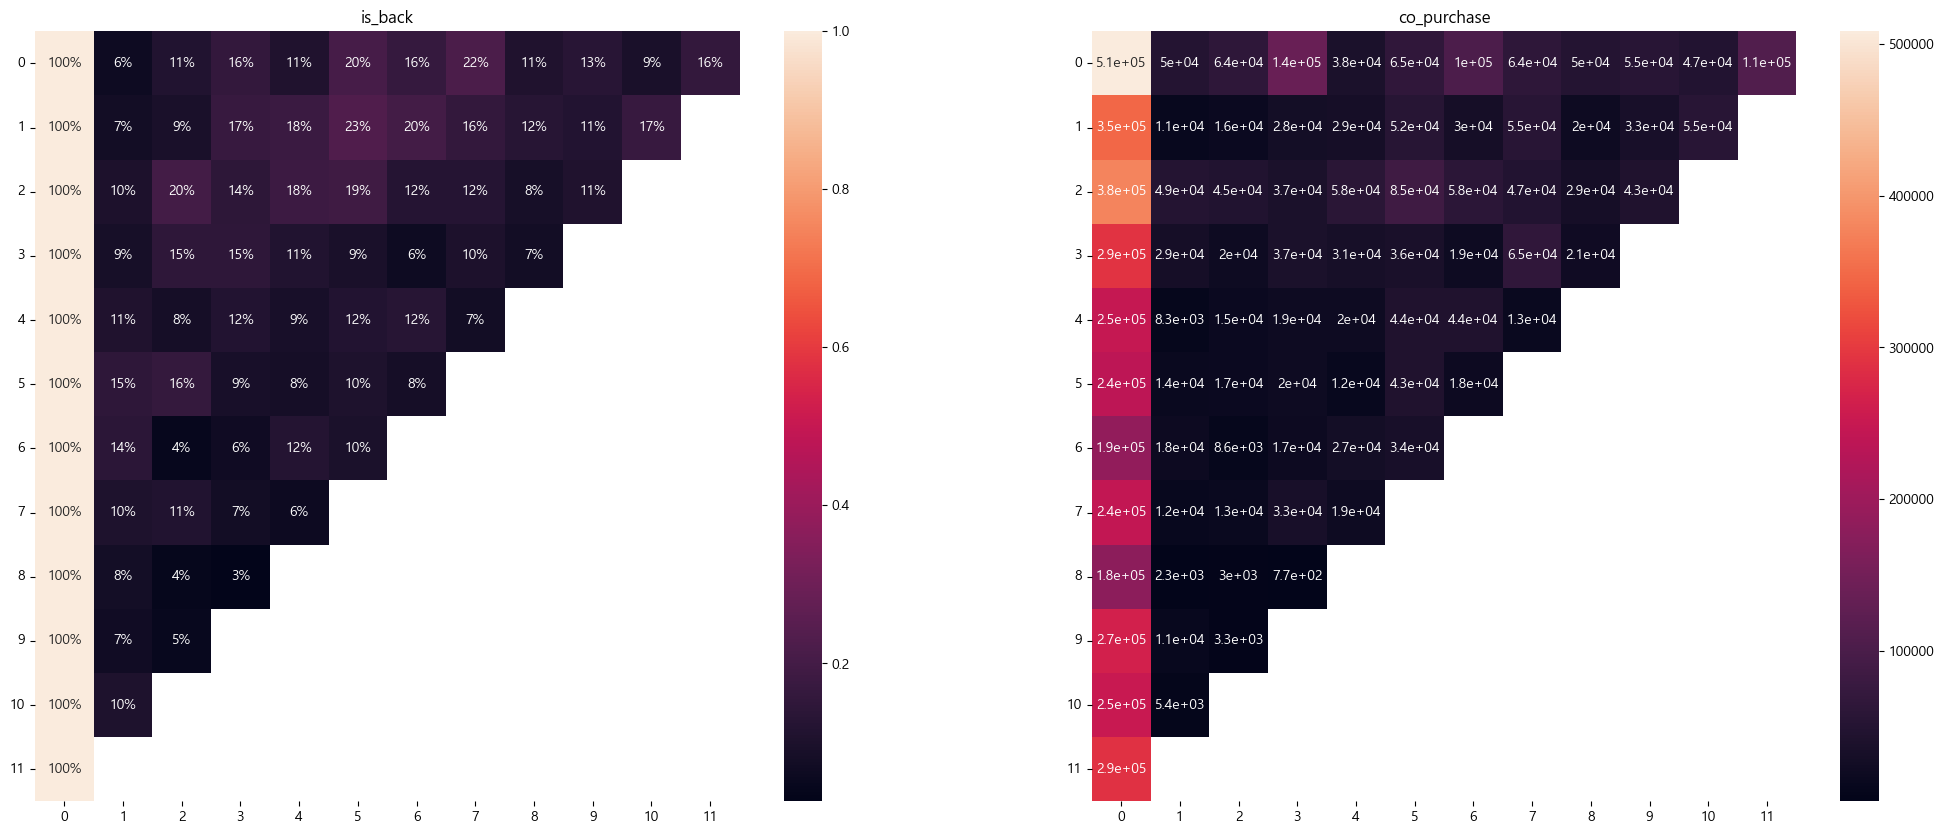

In [9]:
plt.rcParams['figure.figsize'] = (25,10)
plt.subplot(1,2,1)
sns.heatmap(is_back, annot=True, fmt = '.0%')
plt.yticks(rotation=360)
plt.title('is_back')

# plt.rcParams['figure.figsize'] = (20,10)
plt.subplot(1,2,2)
sns.heatmap(co_purchase, annot=True)
plt.title('co_purchase')
plt.yticks(rotation=360)
plt.show()

## (2) 클래스 및 함수 정의

In [10]:
# chort_csv를 분석하기 위한 class를 정의한다.
class cohort_analysis: 
    def __init__(self, csv): # 생성자 메서드
        self.df = csv
                
    #################################### Cohort ##############################################
    def change_index_col_number(self, feature, month_colname): # 인덱스 이름 변경, 
        number_set = [i+1 for i in range(len(self.df.columns)) ] # 다루기 쉽도록 컬럼 이름을 0, 1, 2에서 1, 2, 3으로 변경
        self.df.columns = number_set
        self.df.index = list(feature[month_colname]) # 인덱스 이름들을 feature의 특정 컬럼값들로 변경

    def change_for_cohort_graph(self): # 코호트 그래프를 그리기 위해 데이터프레임 변형
        cohort_df_transpose = self.df.T
        cohort_df_new = cohort_df_transpose.copy()
        cohort_df_new.loc[:] = 0 # 0으로 채워진 컬럼 생성, 새로운 데이터프레임을 위한 초석
        for i in cohort_df_new.columns: # 2019-01 등이 컬럼명으로 바뀐 상태
            if i.month ==1: # 1월에 해당하는 데이터는 값을 모두 채운다.
                cohort_df_new[i].loc[:] = list( cohort_df_transpose[i][:] )
            else:
                cohort_df_new.loc[i.month: , i] = list( cohort_df_transpose[i])[: - i.month+1]
                # 2월이면 인덱스 2부터 끝까지 값을 채운다.
                # 2월이라고 생각하면 맨 마지막 값은 없으므로 [ : - (2+1) ] = [ : -1] 마지막에서 하나 빼고 읽는다.
        self.cohort_df_transpose = cohort_df_transpose
        self.cohort_df_new = cohort_df_new

    def cohort_graph(self, xlim = None, ylim = None, title = None):
        colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", # 짙은 파란색, 주황색, 초록색, 빨간색, 보라색, 갈색, 
                  "#e377c2", "#7f7f7f", "#bcbd22", "#17becf", "#aec7e8", "#ffbb78" ] # 분홍색, 회색, 녹색이 섞인 노란색, 청록색, 밝은 파란색. 밝은 주황색
                
        self.cohort_df_new.index = list(self.cohort_df_new.columns.astype(str))
        plt.figure(figsize=(20,5))
        for i in self.cohort_df_new.columns:
            if i.month ==1:
                plt.plot(self.cohort_df_new.index, self.cohort_df_new[i], 
                         marker='o', label = i, color =  colors[i.month-1])
            else: # 1월이 아닌 경우에는 시작점을 다르게 한다. 예를 들어 2월인 경우에는 두 번째부터 그래프를 그리도록 한다.
                plt.plot(self.cohort_df_new.index[i.month-1:], self.cohort_df_new[i][i.month-1:], 
                         marker='o', label = i, color =  colors[i.month-1])
        if xlim is not None:
            plt.xlim(xlim)
        if ylim is not None: 
            plt.ylim(ylim)
        if title is not None:
            plt.title(title)
        plt.legend()
        plt.xticks(rotation=45)
        plt.grid()
        plt.show()
    
    def cohort_graph_subplot(self, xlim=None, ylim=None, title = None):
        colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", # 짙은 파란색, 주황색, 초록색, 빨간색, 보라색, 갈색, 
                  "#e377c2", "#7f7f7f", "#bcbd22", "#17becf", "#aec7e8", "#ffbb78" ] # 분홍색, 회색, 녹색이 섞인 노란색, 청록색, 밝은 파란색. 밝은 주황색
                
        self.cohort_df_new.index = list(self.cohort_df_new.columns.astype(str))
        plt.figure(figsize=(15,20))
        for i in self.cohort_df_new.columns:
            if i.month ==1:
                plt.subplot(6, 2, i.month)
                plt.plot(self.cohort_df_new.index, self.cohort_df_new[i], marker='o', 
                         label = i, color =  colors[i.month-1], linewidth = '1.1')
                if xlim is not None:
                    plt.xlim(xlim)
                if ylim is not None:
                    plt.ylim(ylim)
                if title is not None:
                    plt.title(title)
                plt.legend()
                plt.xticks(rotation=30)
                plt.grid()
            else:
                plt.subplot(6, 2, i.month)
                plt.plot(self.cohort_df_new.index[i.month-1:], self.cohort_df_new[i][i.month-1:], 
                         marker='o', label = i, color =  colors[i.month-1], linewidth = '1.1')
                if xlim is not None:
                    plt.xlim(xlim)
                if ylim is not None:
                    plt.ylim(ylim)
                   
                plt.legend()
                plt.xticks(rotation=30)
                plt.grid()
                
        plt.show()

def to_month(df, x): # 특정 컬럼 데이터 형식을 월 형식으로 변경 후 문자형 타입으로 변형
    df[x] = pd.to_datetime(df[x])
    df[x] = df[x].dt.to_period('M')
    df[x] = df[x].astype(str)
    return df

class calendar_control: # 달력을 원하는 형태로 가공하기 위한 클래스
    def __init__(self, start_month, number, col_name):
        self.col_name = col_name
        self.df = pd.DataFrame({self.col_name: [] })
        self.start_month = start_month
        self.year, self.month = map(int, self.start_month.split('-')) 
        self.number = number

    def calendar_maker(self):
        month_list = []
        fin_list = []
        for i in range(self.month, self.number+1): # month를 원하는 만큼 채운다.
            month_list.append(i)
        for i in month_list: 
            fin_list.append(str(self.year) + '-' + str(i))
        self.df[self.col_name] = fin_list
        self.df[self.col_name] = pd.to_datetime(self.df[self.col_name]).dt.to_period('M')



In [11]:
cal = calendar_control('2019-01', 12, 'month') # 12월까지 달력을 생성
cal.calendar_maker()
cal_df = cal.df
cal_df

,month
0,2019-01
1,2019-02
2,2019-03
3,2019-04
4,2019-05
5,2019-06
6,2019-07
7,2019-08
8,2019-09
9,2019-10


## (3) Cohort 그래프 분석
- is_back 그래프 분석
- co_purchase 그래프 분석

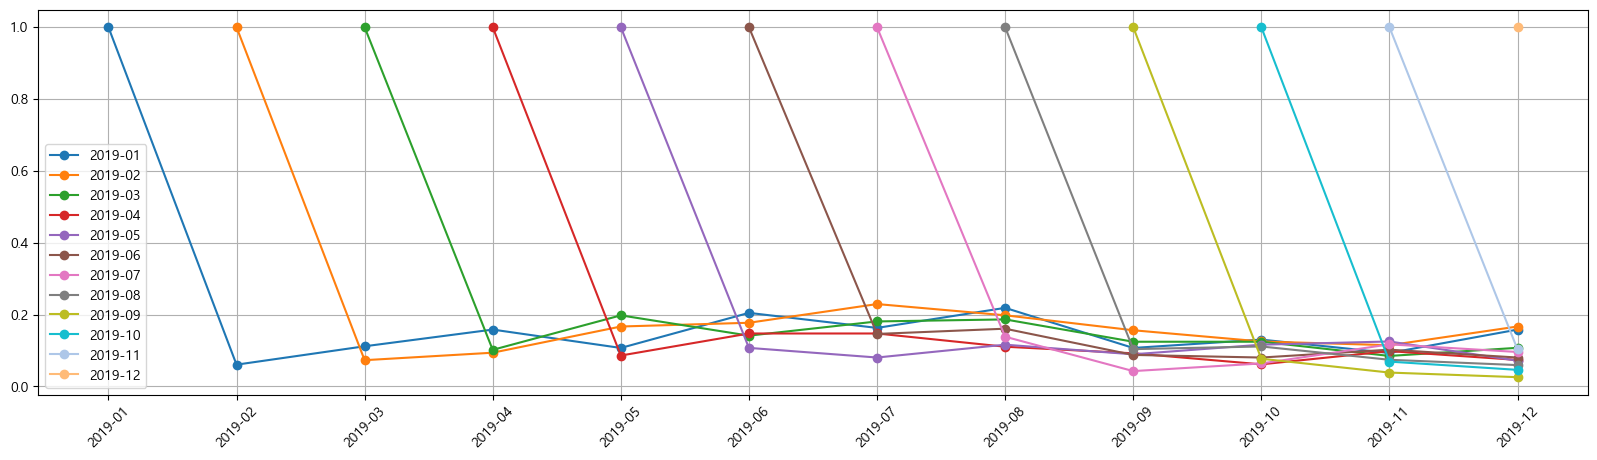

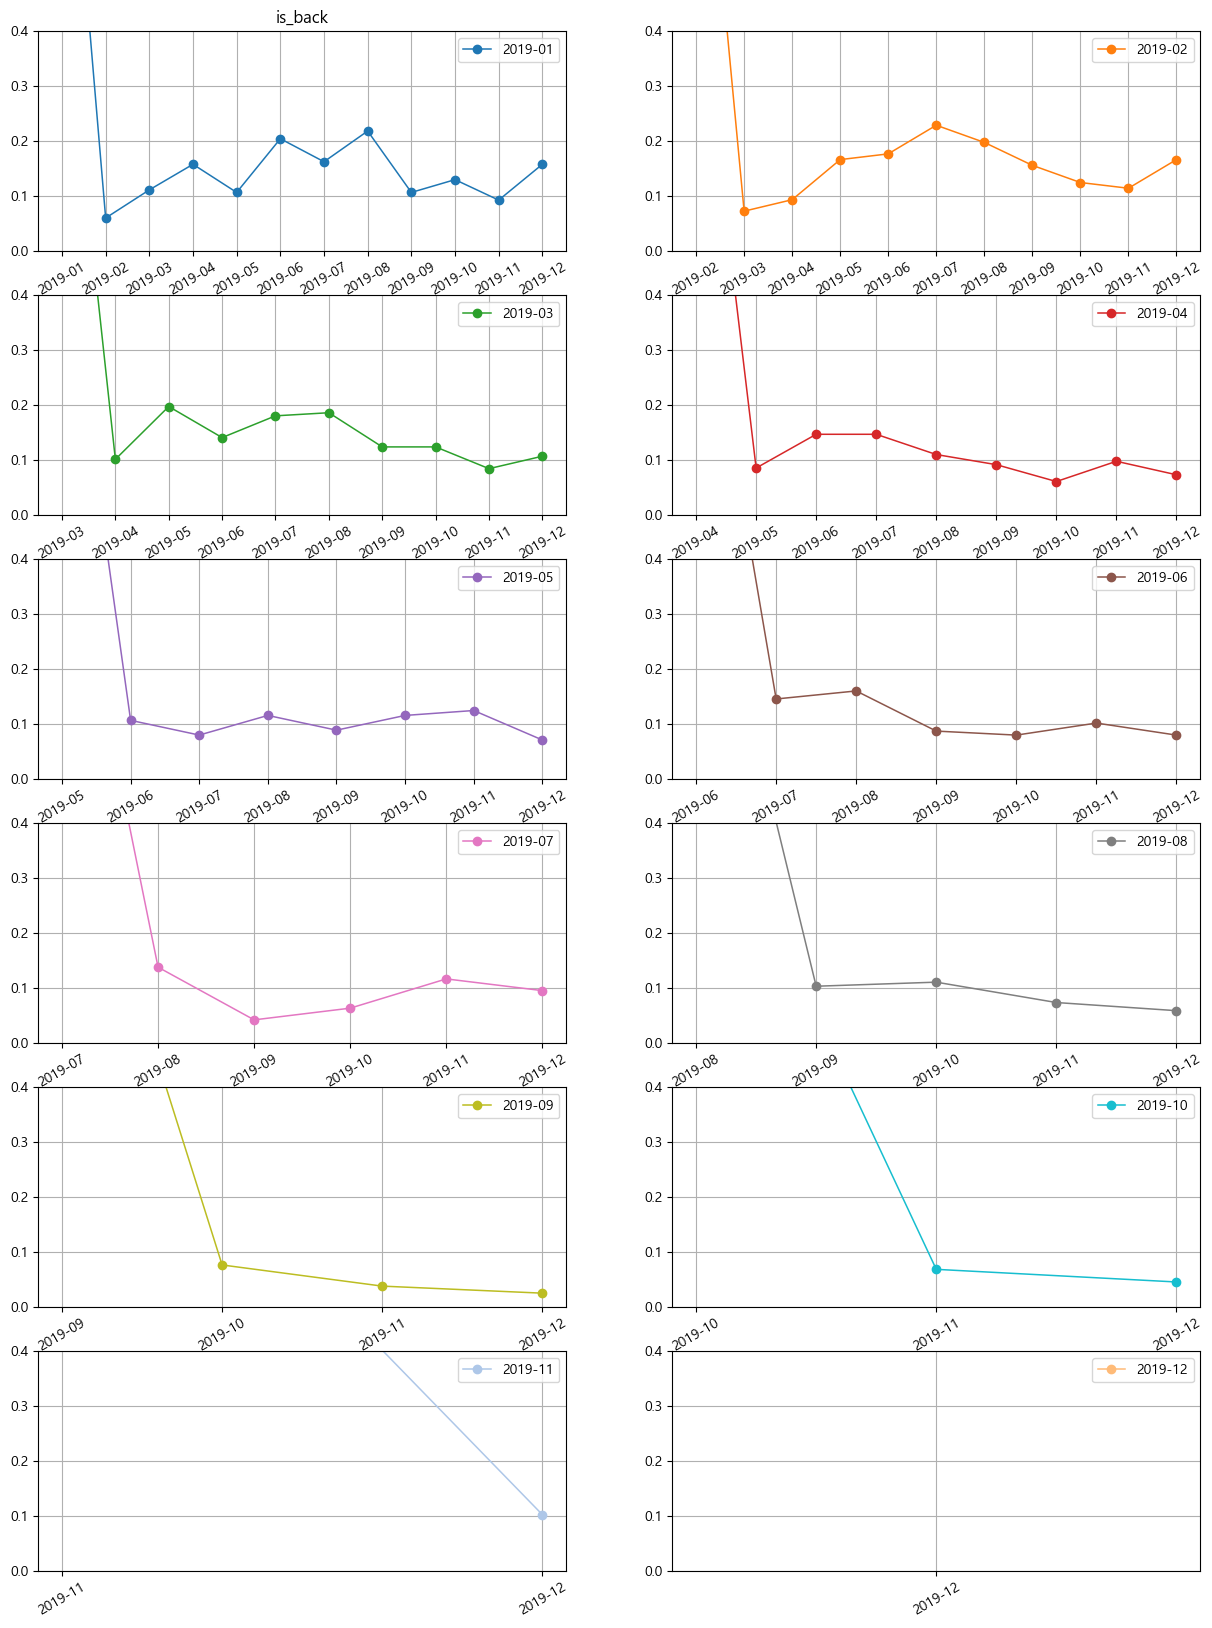

In [12]:
# 재방문율의 변화가 어떻게 되는지 시각화하여 확인한다.
is_back = cohort_analysis(pd.read_csv('./preprocessing/is_back.csv') )
is_back.change_index_col_number(feature = cal_df, month_colname = 'month')

is_back.change_for_cohort_graph() # 코호트 그래프를 그리기에 적합한 형태로 데이터를 다듬는다.

is_back.cohort_graph()
is_back.cohort_graph_subplot(title = 'is_back', xlim = None, ylim = [0, 0.4])

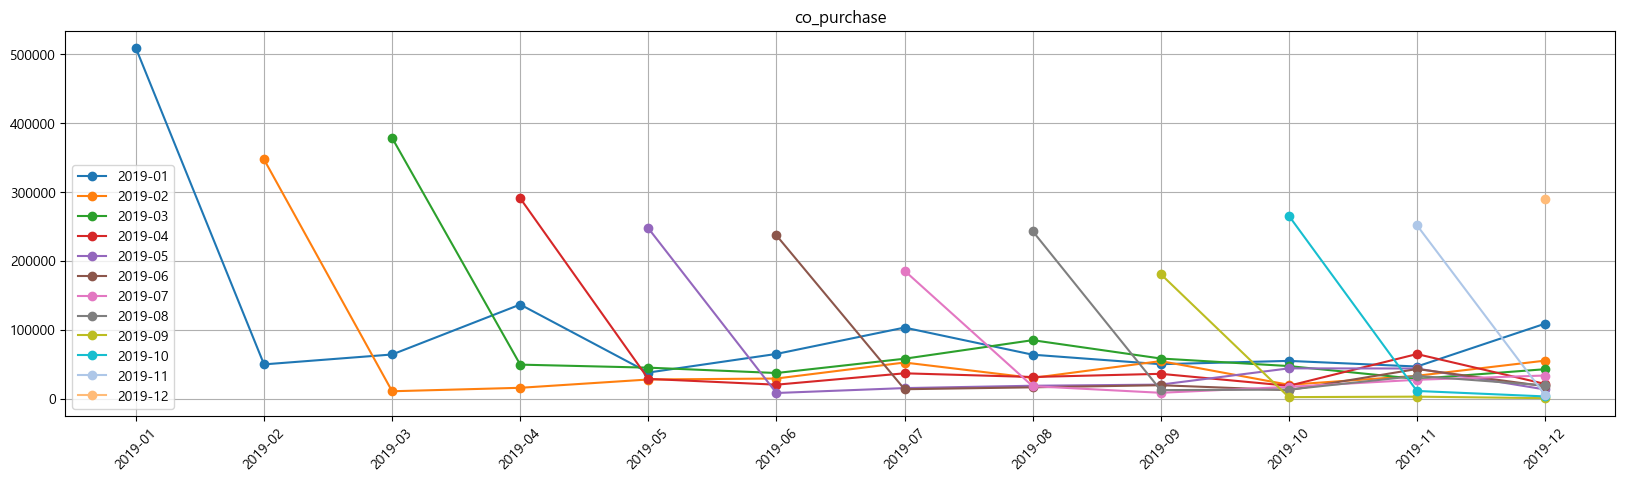

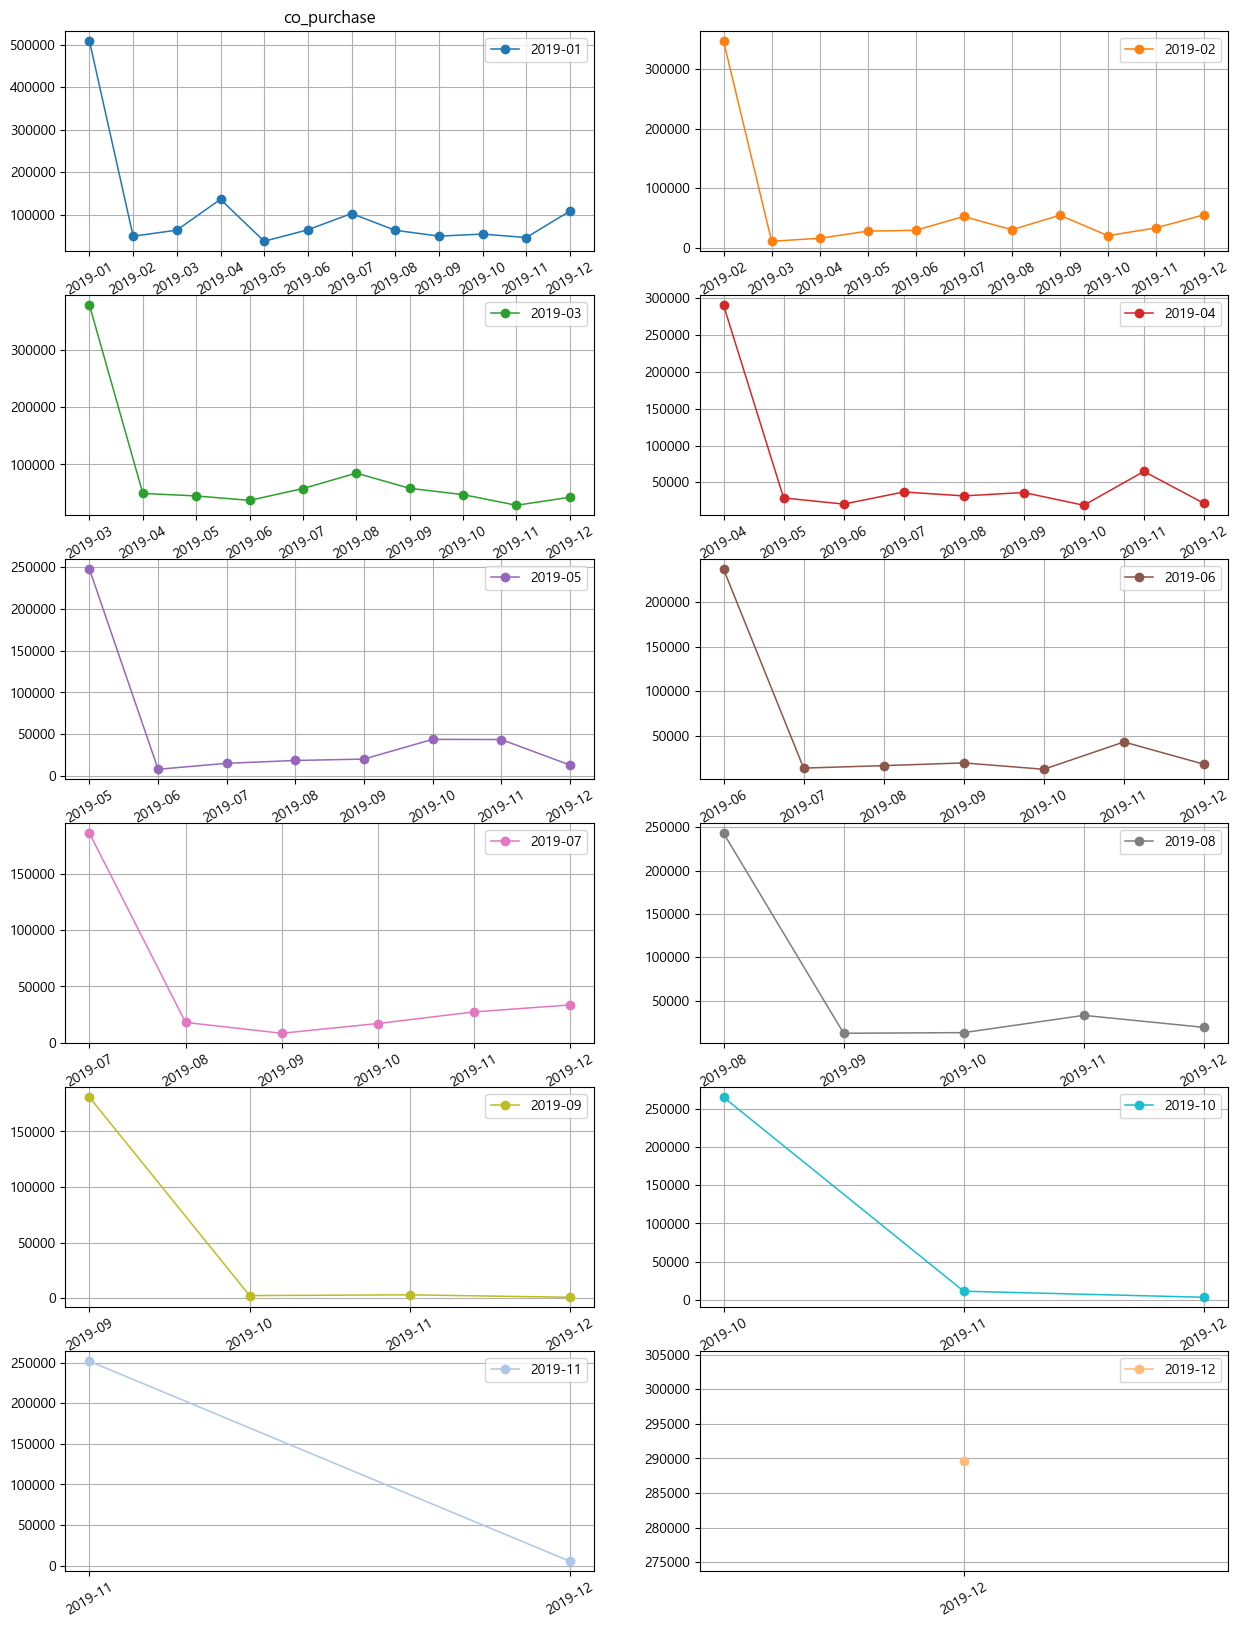

In [13]:
# 거래금액의 변화가 어떻게 되는지 시각화하여 확인한다.
co_purchase = cohort_analysis(pd.read_csv('./preprocessing/co_purchase.csv'))
co_purchase.change_index_col_number(feature = cal_df, month_colname = 'month')

co_purchase.change_for_cohort_graph()

co_purchase.cohort_graph(title = 'co_purchase')
co_purchase.cohort_graph_subplot(title = 'co_purchase')

## (4) 코호트 군집 분석, Feature Engineering

In [14]:
def up_down_check(df): # 전월 대비 증감이 얼마나 있었는지 확인
    dict_df = {}
    for i in df.columns:
        count=0
        for j in range(1, len(df.columns)):
            if df.loc[j,i] < df.loc[j+1,i]: # 뒤에 오는 숫자가 더 크다.
                count+=1
            elif df.loc[j,i] > df.loc[j+1,i]: # 뒤에 오는 숫자가 더 작다.
                count-=1
        dict_df[str(i)] = count # 년도-월 key에 up-down 횟수가 check된 정수 값이 추가된다.
    return dict_df

# 모든 정보가 들어있는 "total_information"에 대해 월 단위 기간 동안 코호트 군집의 변화에 대한 정보를 추가한다.
# 각 고객의 첫 번째 구매월에 대해 결합을 진행하면 된다.
def up_down_merge(df, up_down_dict, new_col_name, period_col): # updown 정보를 결합
    for i in up_down_dict.keys(): # 년도-월 값이 key 값이므로 월이 차례대로 출력
        df.loc[df[period_col]==i, new_col_name] = up_down_dict[i] # 월에 숫자 정보를 준다.
    return df

is_back_temp = is_back.df.T
is_back_temp = is_back_temp.fillna(0)
is_back_up_down = up_down_check(is_back_temp) # 월에 대한 up-down 정보가 기록된 딕셔너리 완성

co_purchase_temp = co_purchase.df.T
co_purchase_temp = co_purchase_temp.fillna(0)
co_purchase_up_down = up_down_check(co_purchase_temp) # 월에 대한 up-down 정보가 기록된 딕셔너리 완성

total_information_first_ord = total_information.groupby('고객ID', as_index=False)['거래날짜'].min() # 월 정보만 추출하는 용도
total_information_first_ord = to_month(total_information_first_ord,'거래날짜')

up_down_df = up_down_merge(df=total_information_first_ord, up_down_dict=is_back_up_down,
                           new_col_name ='is_back_up_down', period_col = '거래날짜')
up_down_df = up_down_merge(df=total_information_first_ord, up_down_dict=co_purchase_up_down,
                           new_col_name ='co_purchase_up_down', period_col = '거래날짜')

## (5) 분석 - 마케팅 비용과 코호트 군집 간의 상관관계 분석

## 데이터프레임에 up-dowon 정보 기입  

In [15]:
# 코호트 군집이 기간 동안 전월 대비 재방문율, 거래금액 합계이 어떻게 변화했는지 계산한다.
# 상관분석을 통하여 당월의 마케팅 비용과 상관관계가 있는지 확인한다.
# Marketing_info.csv 데이터에는 일 단위로 오프라인과 온라인에 대한 마케팅 비용이 적혀있다.
# 월 단위로 각각 마케팅 비용과 마케팅 비용의 합계가 얼마인지 groupby를 진행하고 이를 활용한다.
up_down_df_cohort = up_down_df.copy()
up_down_df_cohort.drop_duplicates(subset=['거래날짜', 'is_back_up_down', 'co_purchase_up_down'], keep='first', 
                                  inplace=True, ignore_index=True) # 월에 대해 동일한 up-down count 값이 들어있다.
up_down_df_cohort.drop('고객ID', axis=1, inplace=True) # 처음부터 월 정보만 가져오는 것이 목적이었으므로 고객ID는 drop
up_down_df_cohort.sort_values(by='거래날짜', inplace=True)
up_down_df_cohort.reset_index(drop=True, inplace=True)
up_down_df_cohort.rename(columns = {'거래날짜':'날짜'}, inplace=True)

## 마케팅 비용 csv에서 월에 대한 마케팅 비용 합계를 추출하고 위에서 구한 데이터프레임에 결합

In [16]:
Marketing_info_cohort = Marketing_info.copy()
Marketing_info_cohort['마케팅비용합계'] = Marketing_info_cohort['오프라인비용'] + Marketing_info_cohort['온라인비용']
Marketing_info_cohort = to_month(Marketing_info_cohort,'날짜')
Marketing_info_cohort = Marketing_info_cohort.groupby(by='날짜', as_index=False)[['오프라인비용','온라인비용', '마케팅비용합계']].sum()
cohort_relation = pd.merge(up_down_df_cohort, Marketing_info_cohort, on='날짜', how='inner')
cohort_relation

,날짜,is_back_up_down,co_purchase_up_down,오프라인비용,온라인비용,마케팅비용합계
0,2019-01,1.0,1.0,96600,58328.95,154928.95
1,2019-02,-1.0,3.0,81300,55807.92,137107.92
2,2019-03,-1.0,-4.0,73500,48750.09,122250.09
3,2019-04,-4.0,-3.0,96000,61026.83,157026.83
4,2019-05,-2.0,0.0,65500,52759.64,118259.64
5,2019-06,-3.0,-1.0,80500,53818.14,134318.14
6,2019-07,-2.0,0.0,67500,52717.85,120217.85
7,2019-08,-3.0,-1.0,85500,57404.15,142904.15
8,2019-09,-4.0,-2.0,83000,52514.54,135514.54
9,2019-10,-3.0,-3.0,93500,57724.65,151224.65


<Axes: xlabel='마케팅비용합계', ylabel='Count'>

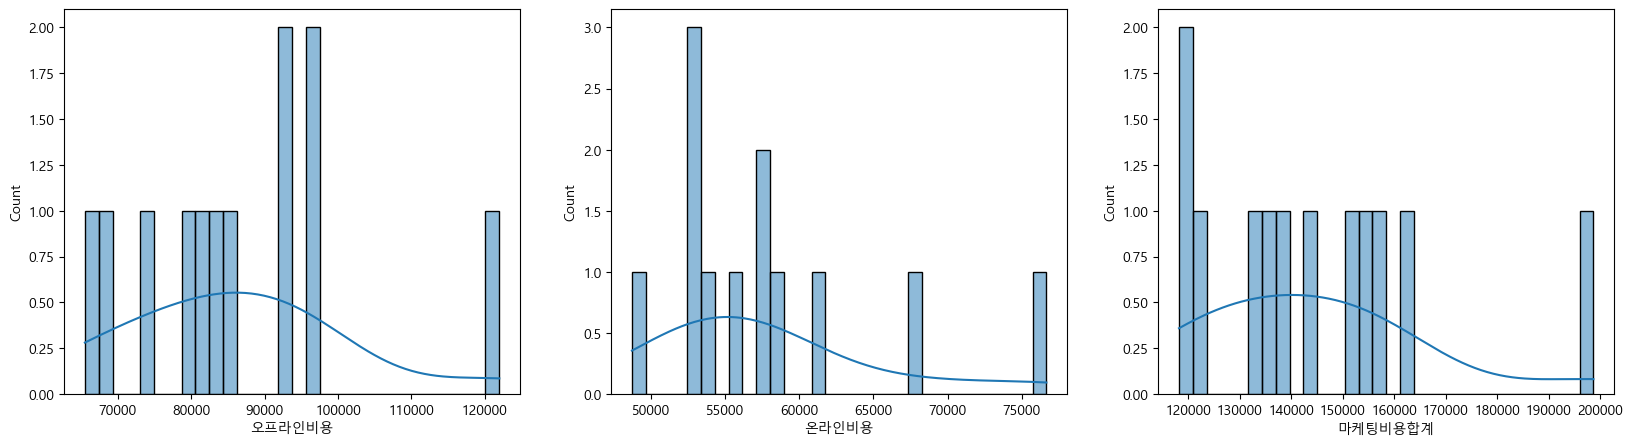

In [17]:
# 상관관계 분석을 수행하기 전에 먼저 정규분포를 어느정도 따르는지 확인한다.
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
sns.histplot(cohort_relation['오프라인비용'], bins=30, kde=True)

plt.subplot(1,3,2)
sns.histplot(cohort_relation['온라인비용'],  bins=30, kde=True)

plt.subplot(1,3,3)
sns.histplot(cohort_relation['마케팅비용합계'],  bins=30, kde=True)

---------------------------------------------------------------------------------------------------- 
pearson 상관계수 분석
----------------------------------------------------------------------------------------------------
오프라인비용


PearsonRResult(statistic=0.1460611697624304, pvalue=0.6505827969743276)

오프라인비용는 타겟에 주는 영향이 미미하다.
온라인비용


PearsonRResult(statistic=0.14816381165814474, pvalue=0.6458419451472264)

온라인비용는 타겟에 주는 영향이 미미하다.
마케팅비용합계


PearsonRResult(statistic=0.1508538221010427, pvalue=0.6397943582785215)

마케팅비용합계는 타겟에 주는 영향이 미미하다.


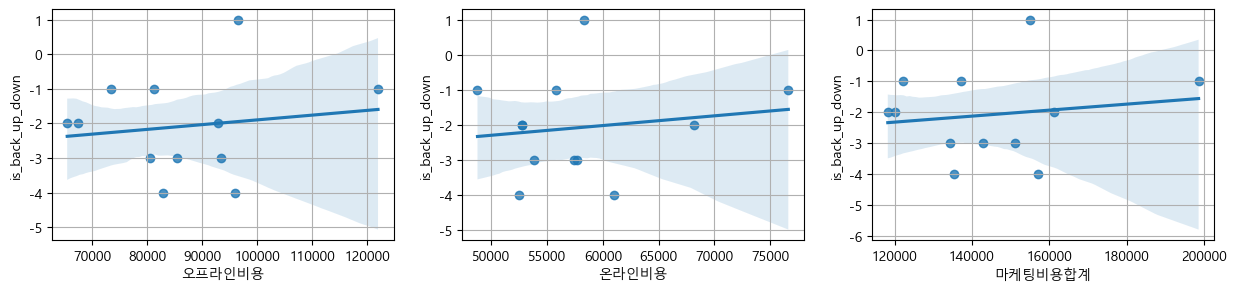

---------------------------------------------------------------------------------------------------- 
pearson 상관계수 분석
----------------------------------------------------------------------------------------------------
오프라인비용


PearsonRResult(statistic=-0.11550376407925637, pvalue=0.7207483705701868)

오프라인비용는 타겟에 주는 영향이 미미하다.
온라인비용


PearsonRResult(statistic=-0.0065738557953640975, pvalue=0.9838230838974683)

온라인비용는 타겟에 주는 영향이 미미하다.
마케팅비용합계


PearsonRResult(statistic=-0.08128708688995041, pvalue=0.8017095098945022)

마케팅비용합계는 타겟에 주는 영향이 미미하다.


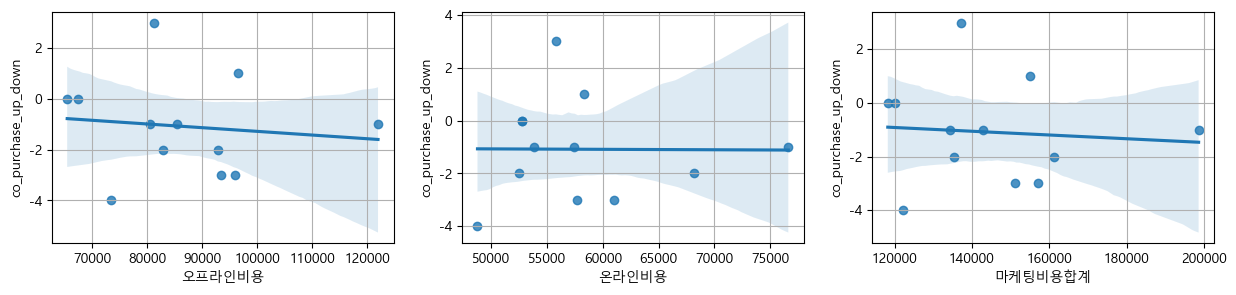

In [18]:
# regplot과 pearsonr의 p-value 값을 통해 상관관계를 파악한다.
def pearson_analyze(df, target, feature_list):
    print('-'*100, '\npearson 상관계수 분석')
    print('-'*100)
    for feature in feature_list:
        print(f'{feature}')
        result = sp.pearsonr(df[feature], df[target])
        display(result)
        if result[1]>0.05:
            print(f'{feature}는 타겟에 주는 영향이 미미하다.')
        else:
            print(f'{feature}는 타겟과 상관관계를 갖는다.')
    plt.figure(figsize=(15,3))
    plt.subplot(1,3,1)
    sns.regplot(x=feature_list[0], y=target, data=df)
    plt.grid()

    plt.subplot(1,3,2)
    sns.regplot(x=feature_list[1], y=target, data=df)
    plt.grid()
    
    plt.subplot(1,3,3)
    sns.regplot(x=feature_list[2], y=target, data=df)
    plt.grid()
    plt.show()
    
pearson_analyze(cohort_relation, 'is_back_up_down', ['오프라인비용','온라인비용', '마케팅비용합계'])
pearson_analyze(cohort_relation, 'co_purchase_up_down', ['오프라인비용','온라인비용', '마케팅비용합계'])

## 오프라인 마케팅 비용, 온라인 마케팅 비용, 마케팅비용 합계가 코호트 군집에 주는 영향이 미미함을 확인할 수 있다.

## 4. RFM 분석
> (1) RFM 데이터프레임 생성
>- Recency, Frequency, Monetary 컬럼

> (2) Recency, Frequency, Monetary 등급 나누기
> - zscore를 기반으로 구간 내 이상치 최소화
> - Frequency, Monetary의 경우 값의 분포가 매우 넓기 때문에 이상치 최소화를 위해서는 점수가 가장 높은 4등급에 적은 데이터가 할당된다.

> (3) 최종 정보를 'rfm_total_score.csv'로 저장


## (1) RFM 데이터프레임 생성

In [19]:
# 값의 분포가 넓으므로 z_score를 기반으로 이상치를 분석하고 제거하였다.
def z_score(df, check_col): # 이상치 분석 및 제거
    a = pd.DataFrame({'z':[]})
    df_z = df.copy()
    a['z'] = sp.zscore(df[check_col])
    df_z['z'] = a['z']
    df_z = df_z[df_z['z']<3] # 이상치 값에 따라 필요한 데이터만 담는다.
    df_z = df_z[df_z['z']>-3]
    df_z.drop('z', axis=1, inplace = True)
    return df_z

total_information = pd.read_csv('./preprocessing/total_information.csv')
total_information_z = z_score(total_information, 'Total_Purchase_Amount')
total_information_z.to_csv('./preprocessing/total_information_z.csv', index=False) # 전처리 데이터를 csv로 저장
total_information_z = pd.read_csv('./preprocessing/total_information_z.csv') # 읽어서 확인
total_information_z

,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,성별,고객지역,가입기간,GST,Total_Purchase_Amount
0,USER_1358,Transaction_0000,2019-01-01,Product_0981,Nest-USA,1,153.71,6.50,Used,남,Chicago,12,0.10,175.5810
1,USER_1358,Transaction_0001,2019-01-01,Product_0981,Nest-USA,1,153.71,6.50,Used,남,Chicago,12,0.10,175.5810
2,USER_1358,Transaction_0013,2019-01-01,Product_0983,Nest-USA,2,122.77,6.50,Not Used,남,Chicago,12,0.10,276.5940
3,USER_1358,Transaction_0015,2019-01-01,Product_0984,Nest-USA,1,81.50,6.50,Clicked,남,Chicago,12,0.10,96.1500
4,USER_1358,Transaction_0016,2019-01-01,Product_0981,Nest-USA,1,153.71,6.50,Clicked,남,Chicago,12,0.10,175.5810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52417,USER_0442,Transaction_7918,2019-05-04,Product_0850,More Bags,5,17.59,18.12,Clicked,여,California,13,0.18,121.9010
52418,USER_0557,Transaction_7940,2019-05-04,Product_0850,More Bags,1,17.59,6.00,Not Used,남,California,36,0.18,26.7562
52419,USER_1374,Transaction_8818,2019-05-19,Product_0850,More Bags,1,21.99,6.00,Used,여,Chicago,27,0.18,31.9482
52420,USER_0994,Transaction_9049,2019-05-22,Product_0850,More Bags,1,17.59,51.99,Used,여,New York,46,0.18,72.7462


In [20]:
def RFM_Setting(df, customer_col, period_col, transaction_col, monetary_col):
    df[period_col] = pd.to_datetime(df[period_col])
    last_date = df[period_col].max() # 데이터 내에서 가장 마지막 날짜와 얼마나 가까운지를 기준으로 recency를 구한다.
    recency_data = df.groupby(customer_col, as_index=False)[period_col].max() # recency
    recency_data['Recency'] = (last_date- recency_data[period_col]).dt.days
    
    frequency_data = df.groupby(customer_col, as_index=False)[transaction_col].count() # frequency
    frequency_data.rename(columns={transaction_col:'Frequency'}, inplace = True)
    
    monetary_data = df.groupby(customer_col, as_index=False)[monetary_col].sum() # monetary
    monetary_data.rename(columns = {monetary_col:'Monetary'}, inplace=True)
    
    rfm_df = pd.merge(recency_data, frequency_data, on=customer_col)
    rfm_df = pd.merge(rfm_df, monetary_data, on=customer_col)
    rfm_df.rename(columns={'거래날짜':'last_ord_date'}, inplace=True)
    return rfm_df

rfm_df = RFM_Setting(df=total_information_z, customer_col='고객ID', period_col='거래날짜', 
                     transaction_col='거래ID', monetary_col='Total_Purchase_Amount')
rfm_df

,고객ID,last_ord_date,Recency,Frequency,Monetary
0,USER_0000,2019-09-15,107,2,185.6882
1,USER_0001,2019-11-02,59,55,6295.6076
2,USER_0002,2019-10-19,73,23,1842.8708
3,USER_0003,2019-12-14,17,17,1636.2142
4,USER_0004,2019-09-15,107,36,2231.7198
...,...,...,...,...,...
1463,USER_1463,2019-04-05,270,7,873.8902
1464,USER_1464,2019-10-05,87,40,3272.6406
1465,USER_1465,2019-06-20,194,8,171.0864
1466,USER_1466,2019-10-23,69,1,333.8000


## (2) Recency, Frequency, Monetary 등급 나누기

In [21]:
# 군집 내에서 값의 분포가 너무 넓게 되지 않도록 적절한 백분위수로 군집을 나눈다.
def grade_setting(x):
    if x <= n1:
        return 1
    elif x > n1 and x <= n2:
        return 2
    elif x > n2 and x <= n3:
        return 3
    else:
        return 4

def grade_setting_reverse(x): # Recency는 값이 작을수록 높은 점수를 부여해야 한다.
    if x <= n1:
        return 4
    elif x > n1 and x <= n2:
        return 3
    elif x > n2 and x <= n3:
        return 2
    else:
        return 1

n1, n2, n3 = np.percentile(rfm_df['Recency'], [25, 50, 75])
print('Recency의 백분위수 :',n1, n2, n3)
rfm_df['Recency_Grade'] = rfm_df['Recency'].apply(grade_setting_reverse)
rg = rfm_df['Recency_Grade'].value_counts().to_frame().sort_values(by='Recency_Grade').reset_index()

n1, n2, n3 = np.percentile(rfm_df['Frequency'], [30, 65, 95])
# n1, n2, n3 = np.percentile(rfm_df['Frequency'], [25, 50, 75])
print('Frequency의 백분위수 :',n1, n2, n3)
rfm_df['Frequency_Grade'] = rfm_df['Frequency'].apply(grade_setting)
fg = rfm_df['Frequency_Grade'].value_counts().to_frame().sort_values(by='Frequency_Grade').reset_index()

n1, n2, n3 = np.percentile(rfm_df['Monetary'], [30, 60, 95])
print('Monetary의 백분위수 :',n1, n2, n3)
rfm_df['Monetary_Grade'] = rfm_df['Monetary'].apply(grade_setting)
mg = rfm_df['Monetary_Grade'].value_counts().to_frame().sort_values(by='Monetary_Grade').reset_index()

Recency의 백분위수 : 55.0 131.0 220.0
Frequency의 백분위수 : 12.0 33.0 114.0
Monetary의 백분위수 : 1014.63536 2796.8686199999997 11252.289644999999


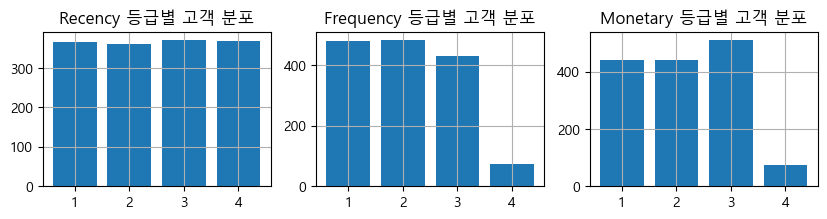

In [22]:
plt.figure(figsize=(10,2))

plt.subplot(1,3,1)
plt.bar('Recency_Grade', 'count', data=rg)
plt.title('Recency 등급별 고객 분포')
plt.grid()

plt.subplot(1,3,2)
plt.bar('Frequency_Grade', 'count', data=fg)
plt.title('Frequency 등급별 고객 분포')
plt.grid()
plt.subplot(1,3,3)
plt.bar('Monetary_Grade', 'count', data=mg)
plt.title('Monetary 등급별 고객 분포')
plt.grid()

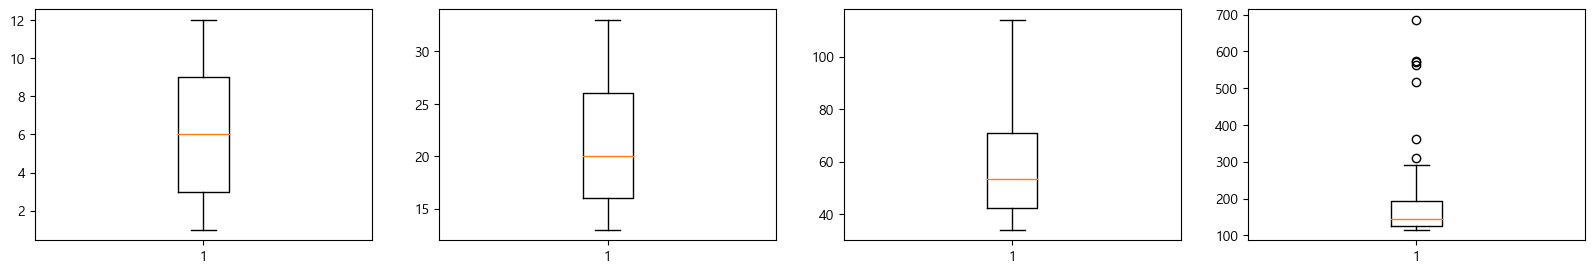

In [57]:
# 위에서 정한 군집의 데이터 분포가 어떻게 되는지 확인한다.
# 데이터프레임을 통해 z-score 기반 이상치가 얼마나 있는지 확인한다.
def RFM_abnormal(df, col, grade_col):
    # display(df[grade_col].value_counts())
    plt.subplot(1,4,1)
    plt.boxplot(df.loc[df[grade_col]==1].sort_values(by=col)[col])
    z_check = sp.zscore(df.loc[df[grade_col]==1][col] ).to_frame()
    # print('-'*100,'\n등급 1 : 이상치 데이터프레임')
    # display(z_check.loc[z_check[col]>=3] )
    # display(z_check.loc[z_check[col]<=-3] )
    
    plt.subplot(1,4,2)
    plt.boxplot(df.loc[df[grade_col]==2].sort_values(by=col)[col])
    z_check = sp.zscore(df.loc[df[grade_col]==2][col] ).to_frame()
    # print('-'*100,'\n등급 2 : 이상치 데이터프레임')
    # display(z_check.loc[z_check[col]>=3] )
    # display(z_check.loc[z_check[col]<=-3] )
    
    plt.subplot(1,4,3)
    plt.boxplot(df.loc[df[grade_col]==3].sort_values(by=col)[col])
    z_check = sp.zscore(df.loc[df[grade_col]==3][col] ).to_frame()
    # print('-'*100,'\n등급 3 : 이상치 데이터프레임')
    # display(z_check.loc[z_check[col]>=3] )
    # display(z_check.loc[z_check[col]<=-3] )
    
    plt.subplot(1,4,4)
    plt.boxplot(df.loc[df[grade_col]==4].sort_values(by=col)[col])
    z_check = sp.zscore(df.loc[df[grade_col]==4][col] ).to_frame()
    # print('-'*100,'\n등급 4 : 이상치 데이터프레임')
    # display(z_check.loc[z_check[col]>=3] )
    # display(z_check.loc[z_check[col]<=-3] )

plt.figure(figsize=(20,3))
# RFM_abnormal(rfm_df, 'Recency', 'Recency_Grade')
RFM_abnormal(rfm_df, 'Frequency', 'Frequency_Grade')
# RFM_abnormal(rfm_df, 'Monetary', 'Monetary_Grade')

### (3) 최종 정보를 'rfm_total_score.csv'로 저장

In [24]:
# RFM 기반 고객 등급과 코호트 군집의 월별 행동 변화를 나타내는 정보를 모두 나타내는 데이터프레임 생성
rfm_df_temp = rfm_df.copy()
rfm_df_temp['is_back_up_down'] = up_down_df['is_back_up_down']
rfm_df_temp['co_purchase_up_down'] = up_down_df['co_purchase_up_down']
rfm_df_temp['is_back_up_down'] = rfm_df_temp['is_back_up_down'].astype(int)
rfm_df_temp['co_purchase_up_down'] = rfm_df_temp['co_purchase_up_down'].astype(int)

rfm_df_temp.to_csv('./preprocessing/rfm_total_score.csv', index=False)
rfm_total_score = pd.read_csv('./preprocessing/rfm_total_score.csv')
rfm_total_score

,고객ID,last_ord_date,Recency,Frequency,Monetary,Recency_Grade,Frequency_Grade,Monetary_Grade,is_back_up_down,co_purchase_up_down
0,USER_0000,2019-09-15,107,2,185.6882,3,1,1,-4,-2
1,USER_0001,2019-11-02,59,55,6295.6076,3,3,3,-1,-4
2,USER_0002,2019-10-19,73,23,1842.8708,3,2,2,-3,-1
3,USER_0003,2019-12-14,17,17,1636.2142,4,2,2,-1,-1
4,USER_0004,2019-09-15,107,36,2231.7198,3,3,2,-4,-2
...,...,...,...,...,...,...,...,...,...,...
1463,USER_1463,2019-04-05,270,7,873.8902,1,1,1,-4,-3
1464,USER_1464,2019-10-05,87,40,3272.6406,3,3,3,-3,-1
1465,USER_1465,2019-06-20,194,8,171.0864,2,1,1,-4,-3
1466,USER_1466,2019-10-23,69,1,333.8000,3,1,1,-3,-3


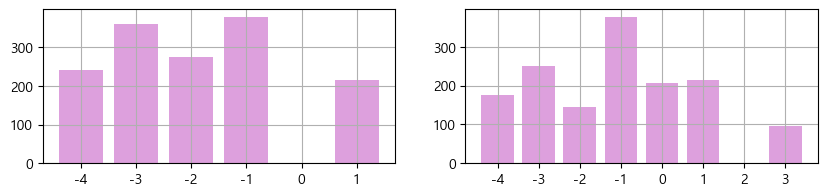

In [25]:
# 코호트 군집의 행동 양상이 어떻게 되는지 확인
plt.figure(figsize=(10,2))
plt.subplot(1,2,1)
plt.bar(rfm_total_score['is_back_up_down'].value_counts().index, 
        rfm_total_score['is_back_up_down'].value_counts().values,  color = 'plum')
plt.grid()
plt.subplot(1,2,2)
plt.bar(rfm_total_score['co_purchase_up_down'].value_counts().index, 
        rfm_total_score['co_purchase_up_down'].value_counts().values, color = 'plum')
plt.xticks(np.arange(-4, 4,1) )
plt.grid()

## 5. RFM 군집 나누기
>1) KMeans 활용 군집 묶기
>2) KMeans 군집의 의미 분석, rfm_kmean_merge.csv로 저장
>3) 차트 작성
>4) 지역별 차트 작성, 어디가 주목할 지역인가?

## (1) KMeans 활용 군집 묶기
> 4개의 군집으로 나누어 분석을 수행한다.

In [26]:
# RFM 등급을 기반으로 군집을 나눌 것이기 때문에 필요가 없는 컬럼을 drop한다.
rfm_analysis = rfm_total_score.copy()
rfm_analysis.drop(['last_ord_date', 'Recency', 'Frequency', 'Monetary', 'is_back_up_down', 'co_purchase_up_down'], 
                  axis=1, inplace=True)

In [27]:
class clustering:
    def __init__(self, df):    
        self.df = df

    def kmeans_cluter(self, cluster_num, n, rs):
        model = KMeans(n_clusters = cluster_num, n_init = n, random_state=rs)
        model.fit(self.df)
        self.kmean = model.predict(self.df)
        self.df['k_group'] = self.kmean

In [28]:
rfm_df_kmeans = clustering(rfm_analysis.copy())
rfm_df_kmeans.df.drop('고객ID', axis=1, inplace=True)

In [29]:
rfm_df_kmeans.kmeans_cluter(4, 10, 50)
rfm_kmean = rfm_df_kmeans.df

In [30]:
rfm_kmean_merge = rfm_analysis.copy().reset_index()
rfm_kmean_merge = pd.merge(rfm_kmean_merge,rfm_kmean.reset_index(), 
                           on=['index','Recency_Grade', 'Frequency_Grade','Monetary_Grade'])
rfm_kmean_merge.drop('index', axis=1, inplace=True)

In [31]:
rfm_kmean_merge.rename(columns={'k_group':'Customer_Segment'},inplace=True)
# rfm_kmean_merge.to_csv('./preprocessing/rfm_kmean_merge.csv',index=False)
pd.read_csv('./preprocessing/rfm_kmean_merge.csv')
rfm_kmean_merge = pd.read_csv('./preprocessing/rfm_kmean_merge.csv')

## (2) KMeans 군집의 의미 분석, rfm_kmean_merge.csv로 저장

In [32]:
# rfm_kmean_Recency = pd.crosstab(rfm_kmean_merge['Customer_Segment'], rfm_kmean_merge['Recency_Grade'], margins=True)
# rfm_kmean_Recency = pd.crosstab(rfm_kmean_merge['Customer_Segment'], rfm_kmean_merge['Recency_Grade'], margins=True)
# rfm_kmean_Recency['0 비율'] = np.round( ( rfm_kmean_Recency[1]/rfm_kmean_Recency['All'] )*100, 2 )
# rfm_kmean_Recency['1 비율'] = np.round( ( rfm_kmean_Recency[2]/rfm_kmean_Recency['All'] )*100, 2 )
# rfm_kmean_Recency['2 비율'] = np.round( ( rfm_kmean_Recency[3]/rfm_kmean_Recency['All'] )*100, 2 )
# rfm_kmean_Recency['3 비율'] = np.round( ( rfm_kmean_Recency[4]/rfm_kmean_Recency['All'] )*100, 2 )

# rfm_kmean_Frequency = pd.crosstab(rfm_kmean_merge['Customer_Segment'], rfm_kmean_merge['Frequency_Grade'], margins=True)
# rfm_kmean_Frequency['0 비율'] = np.round( ( rfm_kmean_Frequency[1]/rfm_kmean_Frequency['All'] )*100, 2 )
# rfm_kmean_Frequency['1 비율'] = np.round( ( rfm_kmean_Frequency[2]/rfm_kmean_Frequency['All'] )*100, 2 )
# rfm_kmean_Frequency['2 비율'] = np.round( ( rfm_kmean_Frequency[3]/rfm_kmean_Frequency['All'] )*100, 2 )
# rfm_kmean_Frequency['3 비율'] = np.round( ( rfm_kmean_Frequency[4]/rfm_kmean_Frequency['All'] )*100, 2 )

# rfm_kmean_Monetary = pd.crosstab(rfm_kmean_merge['Customer_Segment'], rfm_kmean_merge['Monetary_Grade'], margins=True)
# rfm_kmean_Monetary['0 비율'] = np.round( ( rfm_kmean_Monetary[1]/rfm_kmean_Monetary['All'] )*100, 2 )
# rfm_kmean_Monetary['1 비율'] = np.round( ( rfm_kmean_Monetary[2]/rfm_kmean_Monetary['All'] )*100, 2 )
# rfm_kmean_Monetary['2 비율'] = np.round( ( rfm_kmean_Monetary[3]/rfm_kmean_Monetary['All'] )*100, 2 )
# rfm_kmean_Monetary['3 비율'] = np.round( ( rfm_kmean_Monetary[4]/rfm_kmean_Monetary['All'] )*100, 2 )

# rfm_kmean_Recency.to_csv('./preprocessing/rfm_kmean_Recency.csv', index=False)
rfm_kmean_Recency = pd.read_csv('./preprocessing/rfm_kmean_Recency.csv')

# rfm_kmean_Frequency.to_csv('./preprocessing/rfm_kmean_Frequency.csv', index=False)
rfm_kmean_Frequency = pd.read_csv('./preprocessing/rfm_kmean_Frequency.csv')

# rfm_kmean_Monetary.to_csv('./preprocessing/rfm_kmean_Monetary.csv', index=False)
rfm_kmean_Monetary = pd.read_csv('./preprocessing/rfm_kmean_Monetary.csv')

display(rfm_kmean_Recency), display(rfm_kmean_Frequency), display(rfm_kmean_Monetary)

,1,2,3,4,All,0 비율,1 비율,2 비율,3 비율
0,254,255,0,0,509,49.90,50.10,0.00,0.00
1,0,0,181,219,400,0.00,0.00,45.25,54.75
2,112,106,0,0,218,51.38,48.62,0.00,0.00
3,0,0,191,150,341,0.00,0.00,56.01,43.99
4,366,361,372,369,1468,24.93,24.59,25.34,25.14


,1,2,3,4,All,0 비율,1 비율,2 비율,3 비율
0,294,215,0,0,509,57.76,42.24,0.00,0.00
1,0,78,264,58,400,0.00,19.50,66.00,14.50
2,0,37,166,15,218,0.00,16.97,76.15,6.88
3,186,155,0,0,341,54.55,45.45,0.00,0.00
4,480,485,430,73,1468,32.70,33.04,29.29,4.97


,1,2,3,4,All,0 비율,1 비율,2 비율,3 비율
0,284,224,1,0,509,55.80,44.01,0.20,0.00
1,0,21,316,63,400,0.00,5.25,79.00,15.75
2,0,11,196,11,218,0.00,5.05,89.91,5.05
3,157,184,0,0,341,46.04,53.96,0.00,0.00
4,441,440,513,74,1468,30.04,29.97,34.95,5.04


(None, None, None)

> 군집 0 ( = 미관심 고객 )
>- Recency 가장 낮다, Frequency 가장 낮다, Monetary 가장 낮다

> 군집 1 ( = VIP 고객 )
>- Recency 가장 높다, Frequency 가장 높다, Monetary 가장 높다

> 군집 2 ( = 수면 고객, 과거에 활발한 이용 )
>- Recency 낮은 편, Frequency 높은 편, Monetary 높은 편


> 군집 3 ( = 신규 고객 )
>- Recency 높은 편, Frequency 낮은 편, Monetary 낮은 편

In [33]:
rfm_kmean_merge['Customer_Segment'] = rfm_kmean_merge['Customer_Segment'].map({0:'미관심 고객', 
                                                                               1:'VIP 고객', 2:'수면 고객', 3:'신규 고객'})

# rfm_kmean_merge.to_csv('./preprocessing/rfm_kmean_merge_segmentation.csv',index=False)
rfm_kmean_merge = pd.read_csv('./preprocessing/rfm_kmean_merge_segmentation.csv')
rfm_kmean_merge

,고객ID,Recency_Grade,Frequency_Grade,Monetary_Grade,Customer_Segment
0,USER_0000,3,1,1,신규 고객
1,USER_0001,3,3,3,VIP 고객
2,USER_0002,3,2,2,신규 고객
3,USER_0003,4,2,2,신규 고객
4,USER_0004,3,3,2,VIP 고객
...,...,...,...,...,...
1463,USER_1463,1,1,1,미관심 고객
1464,USER_1464,3,3,3,VIP 고객
1465,USER_1465,2,1,1,미관심 고객
1466,USER_1466,3,1,1,신규 고객


## (3) 차트 작성, 다른 차트와 비교하며 인사이트 도출

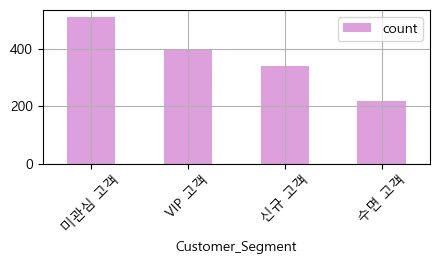

In [34]:
# 군집별로 분포가 얼마나 되는지 시각적으로 확인한다.
rfm_kmean_merge['Customer_Segment'].value_counts().to_frame().plot(kind='bar', figsize=(5,2), color = 'plum')
plt.grid()
plt.xticks(rotation=45)
plt.show()

> VIP고객의 서비스 이용이 꾸준하게 증가하였다

> 신규고객의 서비스 이용이 꾸준히 증가하였다.

## 다른 차트와 함께 비교

In [35]:
# 월별로 고객들의 숫자, 거래 횟수, 거래금액이 얼마가 되는지 확인해본다.
graph_information = pd.read_csv('./preprocessing/total_information.csv')
graph_information['거래날짜'] = pd.to_datetime(graph_information['거래날짜']).dt.to_period('M').astype(str)

graph_customer = graph_information.groupby(by='거래날짜', as_index=False)[['고객ID']].nunique()
graph_transaction = graph_information.groupby(by='거래날짜', as_index=False)[['거래ID']].count()
graph_money = graph_information.groupby(by='거래날짜', as_index = False)['Total_Purchase_Amount'].sum()

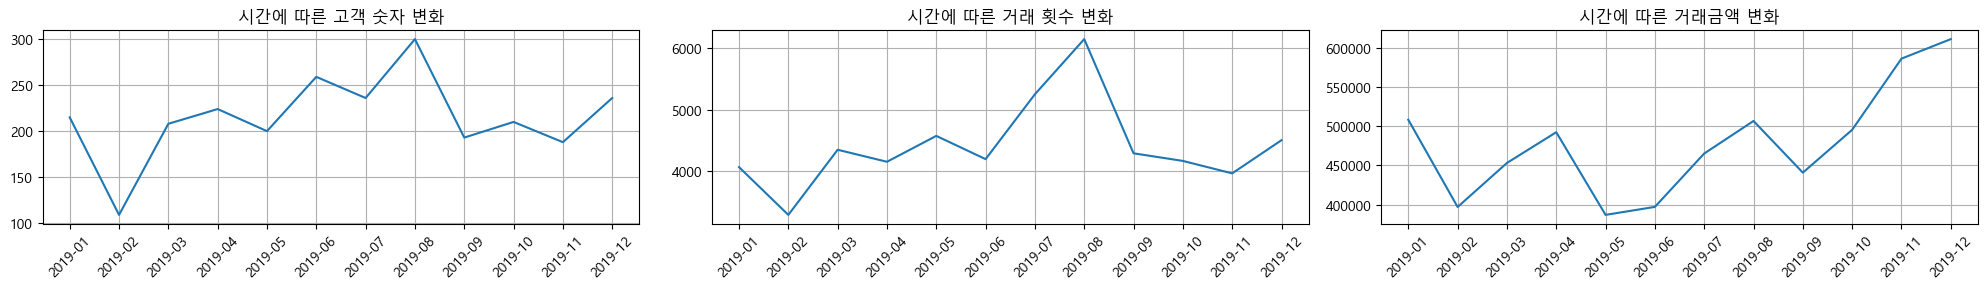

In [36]:
plt.figure(figsize=(20,3))
plt.subplot(1,3,1)
plt.title('시간에 따른 고객 숫자 변화')
plt.plot('거래날짜', '고객ID', data = graph_customer)
plt.xticks(rotation=45)
plt.grid()

plt.subplot(1,3,2)
plt.title('시간에 따른 거래 횟수 변화')
plt.plot('거래날짜', '거래ID', data = graph_transaction)
plt.xticks(rotation=45)
plt.grid()

plt.subplot(1,3,3)
plt.title('시간에 따른 거래금액 변화')
plt.plot('거래날짜', 'Total_Purchase_Amount', data = graph_money)
plt.xticks(rotation=45)
plt.grid()

plt.tight_layout()

## 6. 지역별 차트 작성, 어디가 주목할 지역인가?

In [37]:
# 고객지역, 고객ID, 거래ID, 거래금액을 기반으로 데이터를 시각화한다.
# 고객당 평균 거래금액, 거래당 평균 거래금액, 고객당 평균 거래횟수 컬럼을 추가한다.
class global_analysis_class:
    def __init__(self, df, city_col, customer_ID_col, transaction_ID_col, purchase_col):
        self.df = df
        self.city_col = city_col
        self.customer_info = customer_ID_col
        self.transaction_info = transaction_ID_col
        self.purchase_info = purchase_col

    def group_datasetting(self): # 그래프 시각화를 위한 데이터프레임 전처리
        self.global_customer = self.df.groupby(by = self.city_col, as_index=False)[[self.customer_info]].nunique()
        self.global_transaction = self.df.groupby(by = self.city_col, as_index=False)[[self.transaction_info]].count()
        self.global_money = self.df.groupby(by = self.city_col, as_index=False)[[self.purchase_info]].sum()

        self.global_money_per_customer = self.global_money.copy() # 고객당 평균 거래금액
        self.global_money_per_customer[self.customer_info] = self.global_customer[self.customer_info]
        self.global_money_per_customer['money_per_customer'] = self.global_money[self.purchase_info] / self.global_customer[self.customer_info]
        
        self.global_money_per_transaction = self.global_money.copy() # 거래당 평균 거래금액
        self.global_money_per_transaction[self.transaction_info] = self.global_transaction[self.transaction_info]
        self.global_money_per_transaction['money_per_transaction'] = self.global_money[self.purchase_info] / self.global_transaction[self.transaction_info]
        
        self.global_transaction_per_customer = self.global_transaction.copy()# 고객당 평균 거래횟수
        
        self.global_transaction_per_customer[self.customer_info] = self.global_customer[self.customer_info]# 고객당 평균 거래횟수
        self.global_transaction_per_customer['transaction per customer'] = self.global_transaction[self.transaction_info] / self.global_customer[self.customer_info]

    def basic_graph(self): # 지역별로 고객 숫자, 거래 횟수, 거래금액이 어떻게 되는지 한 행에 그려본다.
        plt.figure(figsize=(20,5)) 
        plt.subplot(1,3,1) # 지역별, 고객 숫자 파악
        plt.bar(self.global_customer[self.city_col], self.global_customer[self.customer_info].values, 
                label = self.global_customer['고객지역'], color = ['indianred', 'skyblue', 'plum', 'orange', 'bisque'])
        plt.title('지역별, 고객 숫자')
        plt.legend()
        plt.xticks(rotation=45)
        plt.grid()
        
        plt.subplot(1,3,2) # 지역별, 거래 횟수 파악
        plt.bar(self.global_transaction[self.city_col], self.global_transaction[self.transaction_info].values, 
                label = self.global_transaction['고객지역'], color = ['indianred', 'skyblue', 'plum', 'orange', 'bisque'])
        plt.title('지역별, 거래 횟수')
        plt.legend()
        plt.xticks(rotation=45)
        plt.grid()
        
        plt.subplot(1,3,3) # 지역별, 거래금액 파악
        plt.bar(self.global_money[self.city_col], self.global_money[self.purchase_info].values, 
                label = self.global_money['고객지역'], color = ['indianred', 'skyblue', 'plum', 'orange', 'bisque'])
        plt.title('지역별, 거래금액')
        plt.legend()
        plt.xticks(rotation=45)
        plt.grid()

    def detail_graph(self): # 위에서 만든 데이터프레임을 바탕으로 평균에 대한 그래프를 그린다.
        plt.figure(figsize=(20,5))
        plt.subplot(1,2,1)
        plt.bar(self.global_money_per_customer[self.city_col], self.global_money_per_customer['money_per_customer'].values, 
                label = self.global_money_per_customer['고객지역'], color = ['indianred', 'skyblue', 'plum', 'orange', 'bisque'] )
        plt.title('지역별, 고객당 평균 거래금액')
        plt.legend()
        plt.xticks(rotation=45)
        plt.grid()
        
        plt.subplot(1,2,2)
        plt.bar(self.global_transaction_per_customer[self.city_col], self.global_transaction_per_customer['transaction per customer'].values, 
                label = self.global_transaction_per_customer['고객지역'], color = ['indianred', 'skyblue', 'plum', 'orange', 'bisque'])
        plt.title('지역별, 고객당 평균 거래 횟수')
        plt.legend()
        plt.xticks(rotation=45)
        plt.grid()

    def gender(self, gender_col, male, female): # 성별에 따른 구매 추이를 pivot 테이블을 통해 파악하고 시각화
        self.gender_col = gender_col
        self.gender_pivot = pd.pivot_table(self.df, index=self.city_col, columns = self.gender_col, values=self.customer_info, aggfunc='nunique')
        self.gender_pivot.plot(kind='bar', color = ['plum', 'bisque'], figsize=(5,3))

## 시각화를 위한 데이터 전처리

In [38]:
global_analysis_byclass = global_analysis_class(pd.read_csv('./preprocessing/total_information.csv'), 
                                                '고객지역', '고객ID', '거래ID', 'Total_Purchase_Amount')
global_analysis_byclass.group_datasetting()

## 지역별 고객당 거래금액, 거래 횟수, 거래금액 시각화

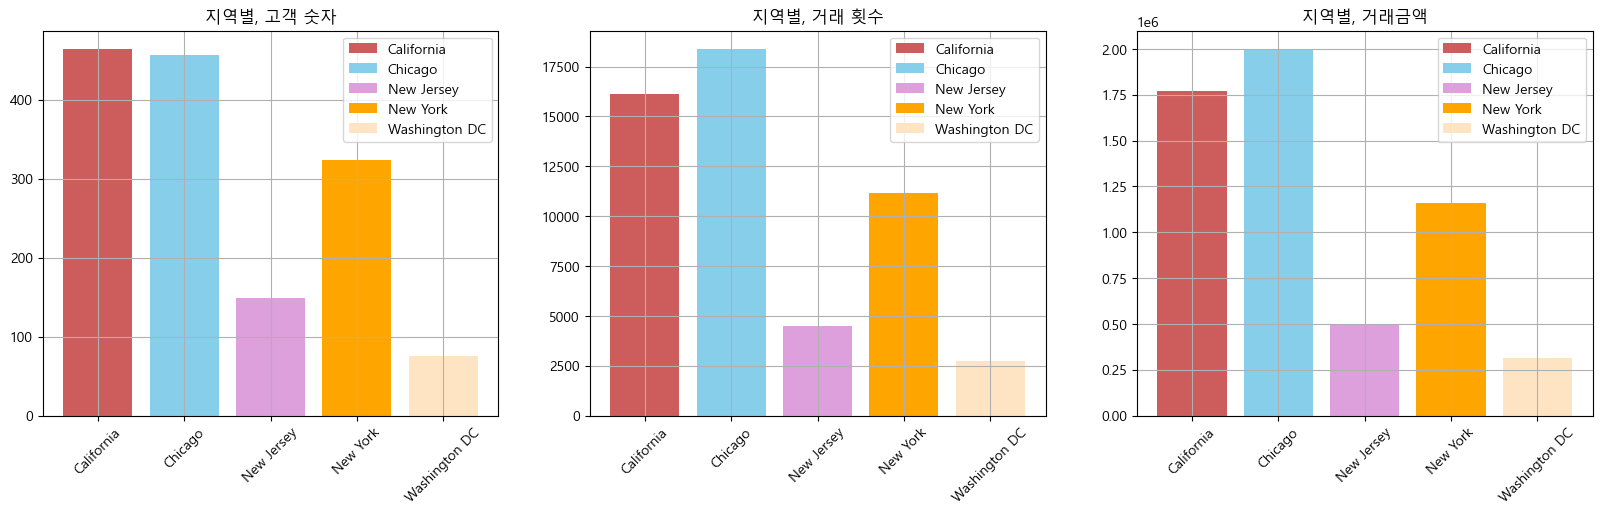

In [39]:
global_analysis_byclass.basic_graph()

## 지역별 고객당 평균 거래금액, 평균 거래 횟수 시각화

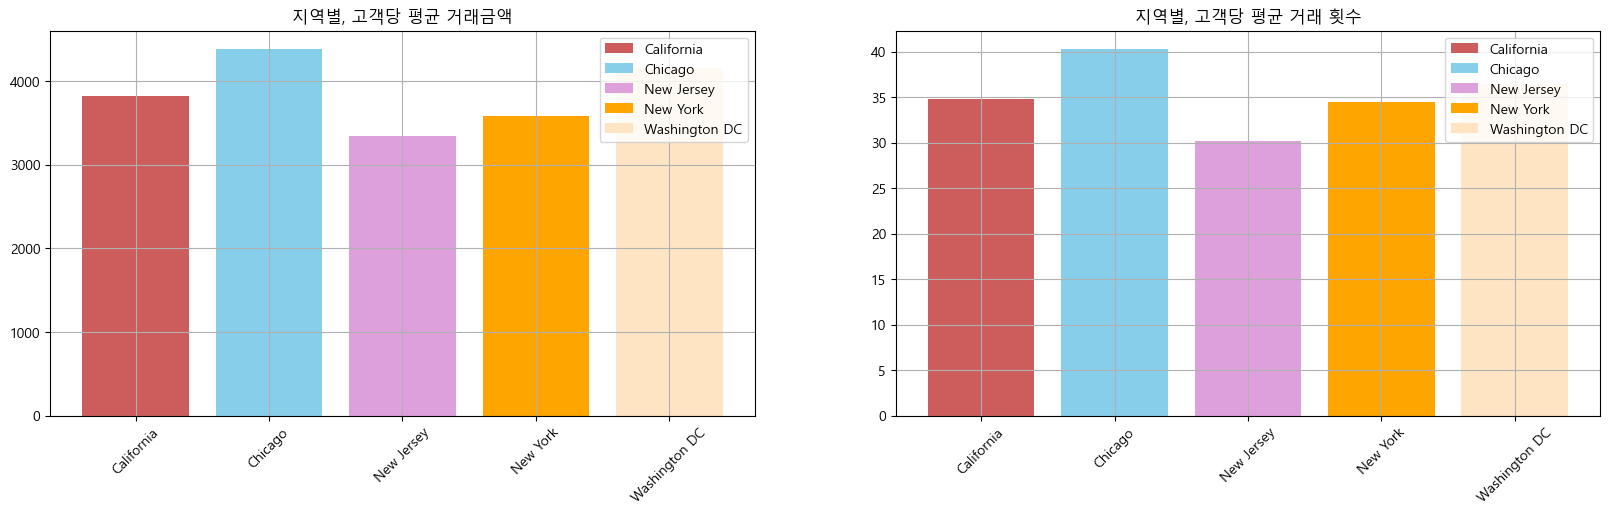

In [40]:
global_analysis_byclass.detail_graph()

In [41]:
graph_product = pd.read_csv('./preprocessing/total_information.csv') 
graph_product = to_month(graph_product, '거래날짜')
graph_product = pd.merge(rfm_kmean_merge, graph_product, on='고객ID').drop(['Recency_Grade', 'Frequency_Grade','Monetary_Grade'], 
                                                                         axis=1)
graph_product_money = pd.pivot_table(graph_product, index='고객지역', columns='제품카테고리', 
                                     values='Total_Purchase_Amount', aggfunc='mean', margins=True).fillna(0)

## 지역에서 품목별 평균 거래금익이 어떻게 되는지 확인

In [42]:
def ratio(df, all_col): # 비율을 구해보자
    df_new = df.copy()
    for i in list(df_new.columns):
        df_new[i] = df_new[i]/df_new['All']
    df_new.drop('All', inplace=True)
    df_new.drop('All', axis=1,inplace=True)
    return df_new
pd.set_option('display.max_columns', None)
graph_product_money = ratio(graph_product_money, 'All')

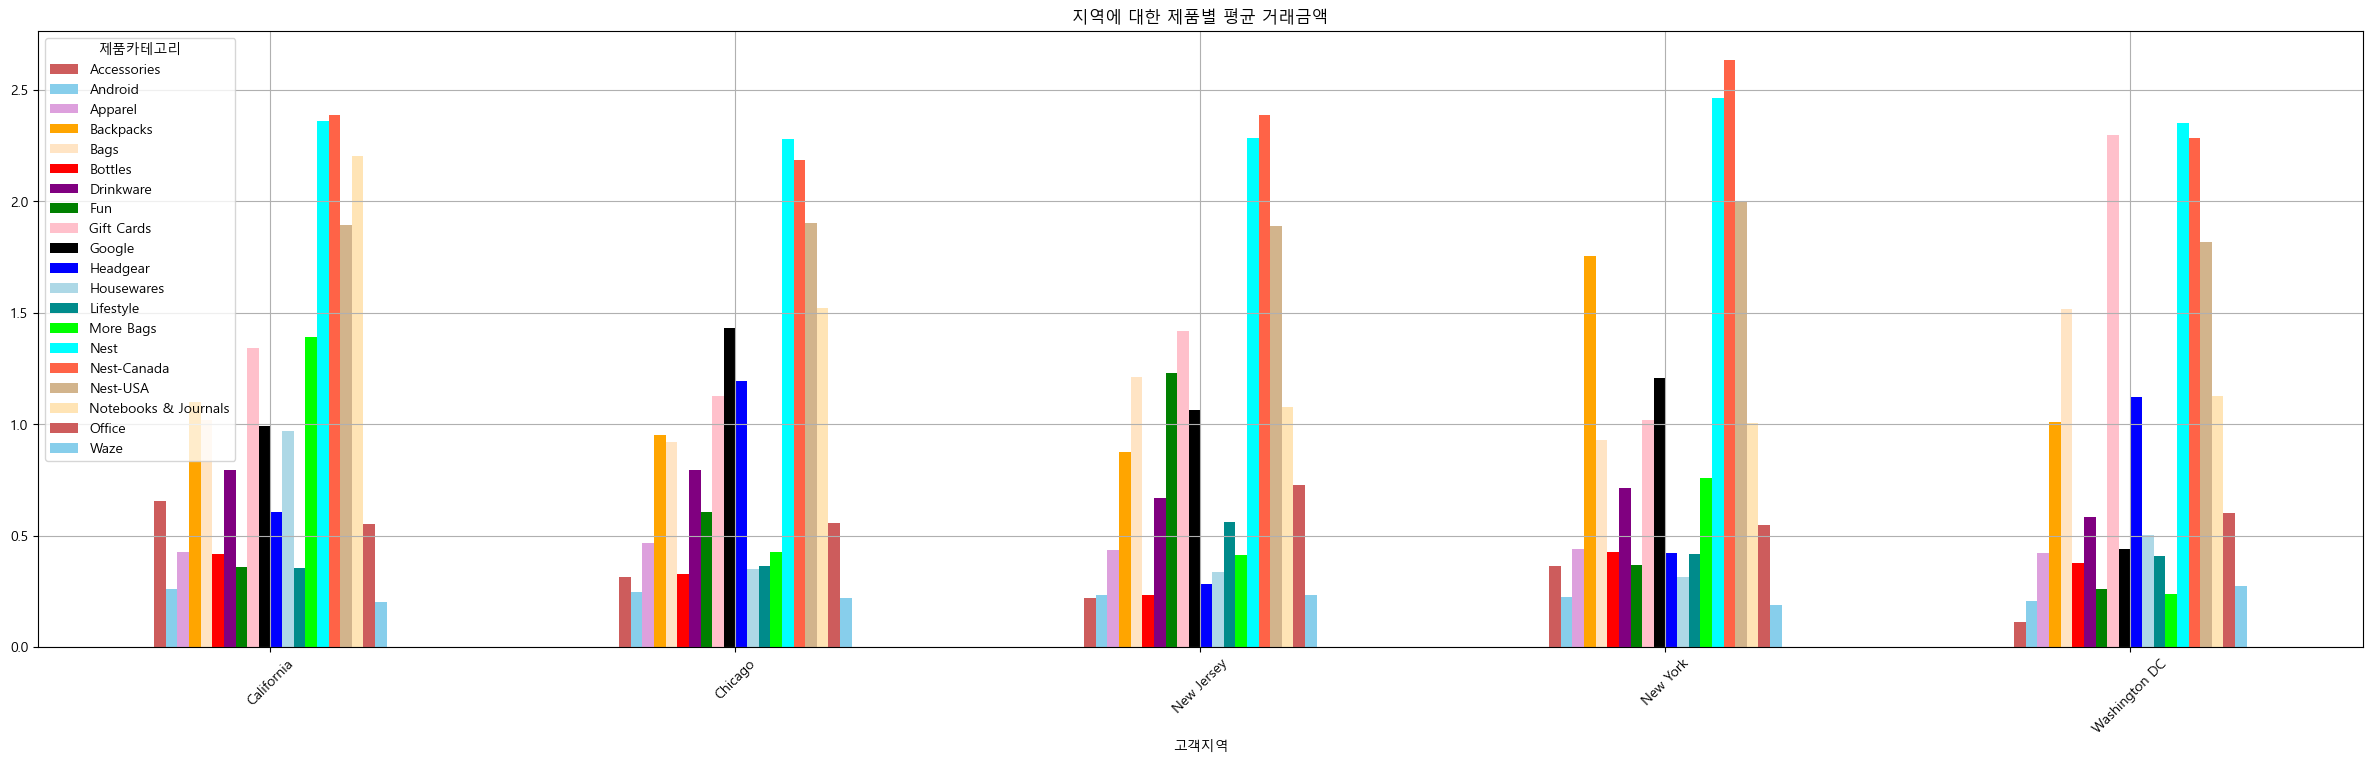

In [43]:
graph_product_money.plot(kind='bar', figsize=(30,8),
                         color = ['indianred', 'skyblue', 'plum', 'orange', 'bisque', 'red', 'purple', 'Green', 'Pink', 'black',
                                    'blue', 'lightblue', 'darkcyan', 'lime','aqua','tomato', 'tan', 'moccasin'])
plt.title('지역에 대한 제품별 평균 거래금액')
plt.xticks(rotation=45)
plt.grid()

## 도시별로 성별 분포는 어떻게 되는지 확인

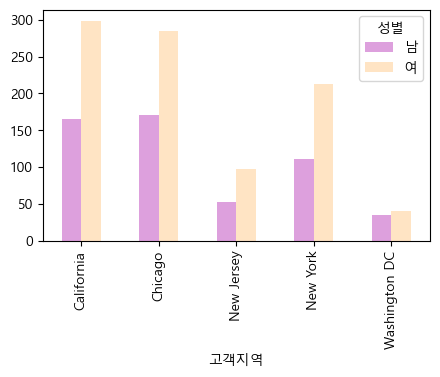

In [44]:
global_analysis_byclass.gender('성별','남', '여')

> California
>- 고객 숫자 많다(1등)
>- 거래 횟수 많다(2등)
>- 소비 금액 많다.(2등)
>- 고객당 평균 거래금액(3등)
>- 1건당 평균 거래금액(3등)
>- 고객당 평균 거래 횟수(3등)

> Chicago
>- 고객 숫자 많다(2등)
>- 거래 횟수 많다(1등)
>- 소비 금액 많다.(1등)
>- 고객당 평균 거래금액(1등) 
>- 1건당 평균 거래금액(4등)
>- 고객당 평균 거래 횟수(1등)

>New Jersey
>- 고객 숫자 적다(4등)
>- 거래 횟수 적다(4등)
>- 소비 금액 적다(4등)
>- 고객당 평균 거래금액(5등)
>- 1건당 평균 거래금액(2등)
>- 고객당 평균 거래 횟수(5등)

>New York
>- 고객 숫자 보통(3등)
>- 거래 횟수 보통(3등)
>- 소비 금액 보통(3등)
>- 고객당 평균 거래금액(4등)
>- 1건당 평균 거래금액(5등)
>- 고객당 평균 거래 횟수(4등)

>Washington DC
>- 고객 숫자 적다(5등)
>- 거래 횟수 적다(5등)
>- 소비 금액 적다(5등)
>- 고객당 평균 거래금액(2등) 
>- 1건당 평균 거래금액(1등)
>- 고객당 평균 거래 횟수(2등)

## 7. 장바구니 분석

In [45]:
# 거래ID별로 제품ID를 리스트로 그룹화
transactions = Onlinesales_info.groupby('거래ID')['제품ID'].apply(list).values.tolist()

# TransactionEncoder를 사용하여 데이터 변환
encoder = TransactionEncoder()
encoded_array = encoder.fit(transactions).transform(transactions)
transaction_df = pd.DataFrame(encoded_array, columns=encoder.columns_)

# apriori 알고리즘을 사용하여 빈번한 아이템 세트 찾기
frequent_itemsets = apriori(transaction_df, min_support=0.01, use_colnames=True)

# 연관 규칙 생성
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1)

# 연관 규칙 출력
print(rules.sort_values(by='confidence', ascending=False).head(10))

      antecedents     consequents  antecedent support  consequent support  \
0  (Product_0917)  (Product_0915)            0.014644            0.017677   
1  (Product_0915)  (Product_0917)            0.017677            0.014644   
2  (Product_0976)  (Product_0983)            0.128886            0.132796   
3  (Product_0983)  (Product_0976)            0.132796            0.128886   

    support  confidence       lift  leverage  conviction  zhangs_metric  
0  0.010654    0.727520  41.156636  0.010395    3.605126       0.990203  
1  0.010654    0.602709  41.156636  0.010395    2.480185       0.993260  
2  0.027653    0.214551   1.615644  0.010537    1.104087       0.437430  
3  0.027653    0.208233   1.615644  0.010537    1.100216       0.439403  


- 규칙 0: 제품 0917을 구매했을 때, 제품 0915를 함께 구매할 확률이 약 72.75% 이 규칙의 lift 값이 41.15로 매우 높으므로, 두 제품 간의 매우 강한 양의 연관성이 있음
- 규칙 1: 제품 0915를 구매했을 때, 제품 0917을 함께 구매할 확률이 약 60.27% lift 값이 규칙 0과 동일하게 높으므로, 이 두 제품은 서로 매우 강한 양의 연관성
- 규칙 3과 2: 제품 0976을 구매했을 때, 제품 0983을 함께 구매할 확률은 약 21.45%, 그리고 그 반대의 경우도 비슷한 확률. 이 규칙들의 lift 값은 1.61로, 두 제품이 서로 구매될 확률이 독립적인 경우보다 약간 더 높음

In [46]:
filtered_data = Onlinesales_info[Onlinesales_info['제품ID'].isin(['Product_0915', 'Product_0917'])]
display(filtered_data)

,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태
232,USER_1267,Transaction_0129,2019-01-03,Product_0915,Lifestyle,1,3.61,6.50,Clicked
300,USER_0284,Transaction_0168,2019-01-03,Product_0915,Lifestyle,1,3.61,6.50,Clicked
302,USER_0284,Transaction_0168,2019-01-03,Product_0917,Lifestyle,1,3.61,6.50,Clicked
422,USER_1358,Transaction_0242,2019-01-04,Product_0915,Lifestyle,26,3.47,6.50,Clicked
424,USER_1358,Transaction_0242,2019-01-04,Product_0917,Lifestyle,26,3.47,6.50,Not Used
...,...,...,...,...,...,...,...,...,...
45908,USER_0234,Transaction_20898,2019-11-13,Product_0917,Lifestyle,3,3.50,6.00,Clicked
45997,USER_0794,Transaction_20945,2019-11-14,Product_0917,Lifestyle,2,2.80,6.00,Not Used
46084,USER_1336,Transaction_20982,2019-11-14,Product_0915,Lifestyle,1,2.80,12.99,Used
46105,USER_0257,Transaction_20996,2019-11-14,Product_0917,Lifestyle,1,2.80,6.00,Not Used


- 상품을 배치하거나 프로모션을 기획할 때 관련성 높게 나온 제품들을 함께 추천하거나 패키지로 묶어 판매하는 전략..
- 예를 들어, 제품 0917과 0915는 함께 묶어 할인을 제공하거나, 함께 구매를 유도하는 마케팅 캠페인을 진행

In [47]:
rfm_kmean_merge = pd.read_csv('./preprocessing/rfm_kmean_merge_segmentation.csv')
total_information_z = pd.read_csv('./preprocessing/total_information_z.csv')

def perform_association_analysis(data, segment_col, transaction_col, product_col):
    # 결과를 저장할 딕셔너리
    association_results = {}

    # 세그먼트별로 분석
    for segment in data[segment_col].unique():
        # 세그먼트 데이터 필터링
        segment_data = data[data[segment_col] == segment]

        # 거래ID별로 제품ID를 리스트로 변환
        transactions = segment_data.groupby(transaction_col)[product_col].apply(list).tolist()

        # TransactionEncoder로 데이터 변환
        te = TransactionEncoder()
        te_ary = te.fit(transactions).transform(transactions)
        df = pd.DataFrame(te_ary, columns=te.columns_)

        # apriori 알고리즘으로 빈번한 아이템 세트를 찾기
        frequent_itemsets = apriori(df, min_support=0.01, use_colnames=True)

        # 연관 규칙을 생성
        rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.1)

        # 세그먼트별 결과 저장
        association_results[segment] = rules

    return association_results

# 데이터프레임에 세그먼트 정보 결합
merged_data = pd.merge(total_information_z, rfm_kmean_merge, on='고객ID')

# 연관 분석 수행
results = perform_association_analysis(merged_data, 'Customer_Segment', '거래ID', '제품ID')

# 결과 확인
for segment, rules in results.items():
    print(f"Results for {segment}:")
    print(rules)  # 또는 print(rules.head())를 사용하여 상위 몇 개의 규칙만 출력할 수 있습니다.
    print("\n")  # 세그먼트 간에 구분을 위해 줄바꿈 추가

Results for 수면 고객:
      antecedents     consequents  antecedent support  consequent support  \
0  (Product_0917)  (Product_0915)            0.014947            0.019218   
1  (Product_0915)  (Product_0917)            0.019218            0.014947   
2  (Product_0915)  (Product_0918)            0.019218            0.013469   
3  (Product_0918)  (Product_0915)            0.013469            0.019218   
4  (Product_0976)  (Product_0983)            0.135512            0.138962   
5  (Product_0983)  (Product_0976)            0.138962            0.135512   
6  (Product_0983)  (Product_0981)            0.138962            0.156866   
7  (Product_0981)  (Product_0983)            0.156866            0.138962   

    support  confidence       lift  leverage  conviction  zhangs_metric  
0  0.010841    0.725275  37.739081  0.010554    3.570046       0.988274  
1  0.010841    0.564103  37.739081  0.010554    2.259826       0.992578  
2  0.010348    0.538462  39.977486  0.010089    2.137484       0.

- 세그먼트 별로 연관 분석해보니 VIP 고객은 해당이 안되는 것 같음
- 수면 고객을 활성화 시키기위해서 묶어서 추천하는 마케팅
- 또는 신규고객과 미관심 고객에게는 해당 마케팅을 하면 그나마 의미가 있을 듯 함. 

## 8. 기타 분석

## 성별 VIP 인기 카테고리

In [48]:
rfm_region_gender = pd.merge(rfm_kmean_merge, total_information, on='고객ID')

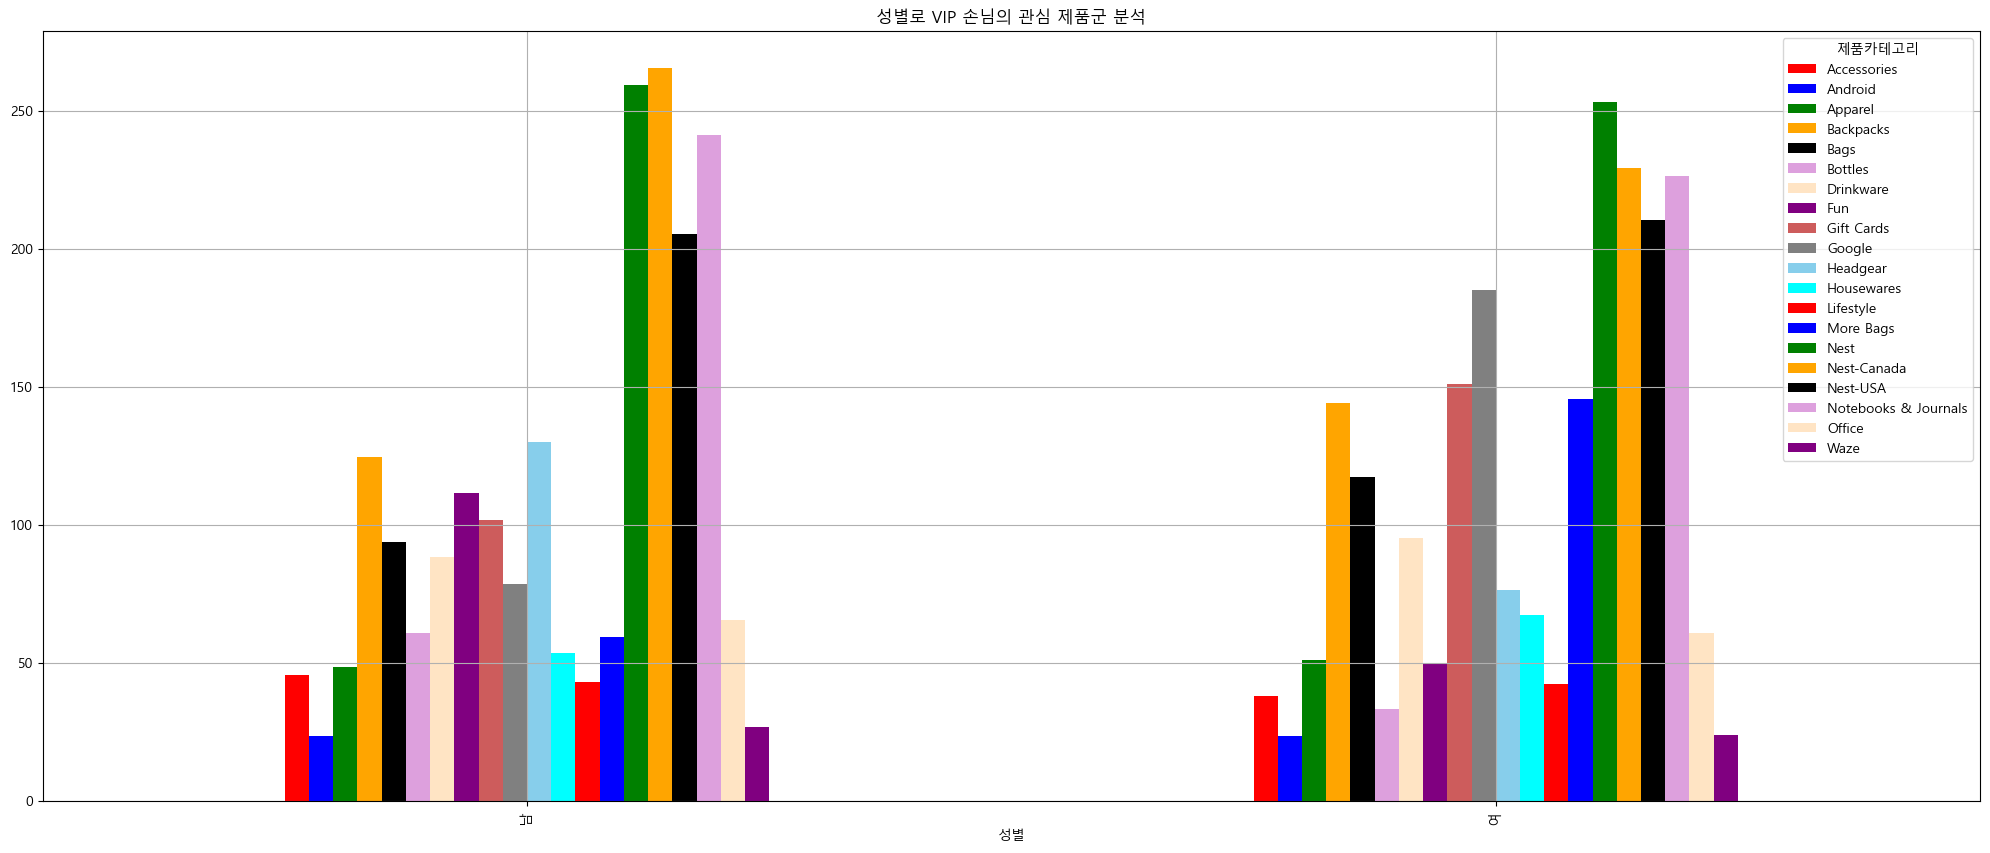

In [49]:
rfm_region_gender = rfm_region_gender.loc[rfm_region_gender['Customer_Segment']=='VIP 고객']
pd.pivot_table(rfm_region_gender, index = '성별', columns = '제품카테고리', 
               values = 'Total_Purchase_Amount', aggfunc='mean').plot(kind='bar', 
                                                                      color = ['Red','blue', 'Green', 'Orange', 'black', 
                                                                               'plum', 'bisque','purple', 'indianred', 'grey',
                                                                               'skyblue', 'cyan'])
plt.title('성별로 VIP 손님의 관심 제품군 분석')
plt.grid()

## 시간에 따른 제품카테고리별 판매량 변화

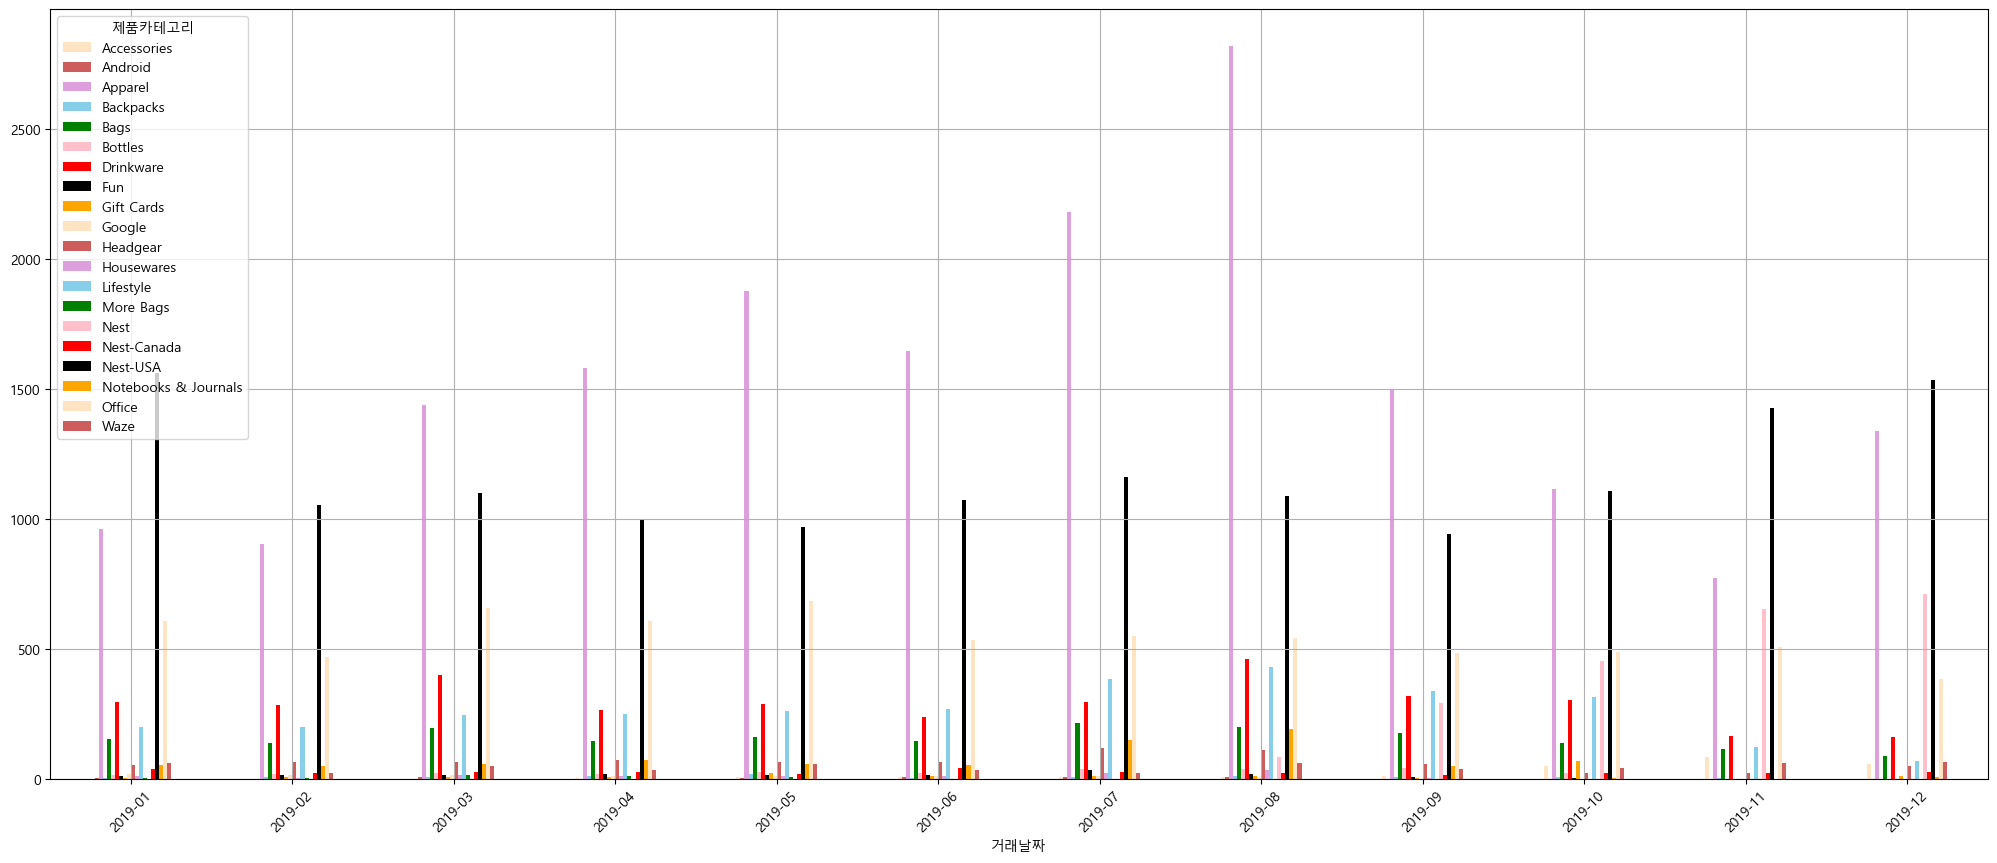

In [50]:
total_information_category = to_month(total_information, '거래날짜' )
total_information_category = pd.pivot_table(total_information_category, 
                                            index = '거래날짜', columns = '제품카테고리', values = '수량', aggfunc='count')
total_information_category.fillna(0, inplace=True)
# total_information_category.drop('Apparel', axis=1, inplace=True)
total_information_category.plot(kind='bar', color = ['bisque', 'indianred', 'plum', 
                                                     'skyblue', 'green', 'pink', 'red', 'black', 'orange'])
plt.grid()
plt.xticks(rotation=45)
plt.show()

## 고객 유형별 관심 제품

,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,성별,고객지역,가입기간,GST,Total_Purchase_Amount,Recency_Grade,Frequency_Grade,Monetary_Grade,Customer_Segment
0,USER_1358,Transaction_0000,2019-01,Product_0981,Nest-USA,1,153.71,6.5,Used,남,Chicago,12,0.10,175.5810,1,4,4,수면 고객
1,USER_1358,Transaction_0001,2019-01,Product_0981,Nest-USA,1,153.71,6.5,Used,남,Chicago,12,0.10,175.5810,1,4,4,수면 고객
2,USER_1358,Transaction_0013,2019-01,Product_0983,Nest-USA,2,122.77,6.5,Not Used,남,Chicago,12,0.10,276.5940,1,4,4,수면 고객
3,USER_1358,Transaction_0015,2019-01,Product_0984,Nest-USA,1,81.50,6.5,Clicked,남,Chicago,12,0.10,96.1500,1,4,4,수면 고객
4,USER_1358,Transaction_0016,2019-01,Product_0981,Nest-USA,1,153.71,6.5,Clicked,남,Chicago,12,0.10,175.5810,1,4,4,수면 고객
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52919,USER_0175,Transaction_23677,2019-12,Product_0992,Nest,1,100.91,6.5,Clicked,여,California,47,0.05,112.4555,4,1,1,신규 고객
52920,USER_0175,Transaction_23678,2019-12,Product_0994,Nest,1,355.74,6.5,Used,여,California,47,0.05,380.0270,4,1,1,신규 고객
52921,USER_0175,Transaction_23678,2019-12,Product_0996,Nest,2,49.95,6.5,Clicked,여,California,47,0.05,111.3950,4,1,1,신규 고객
52922,USER_0972,Transaction_23922,2019-12,Product_0994,Nest,1,355.74,6.5,Clicked,여,New York,41,0.05,380.0270,4,1,1,신규 고객


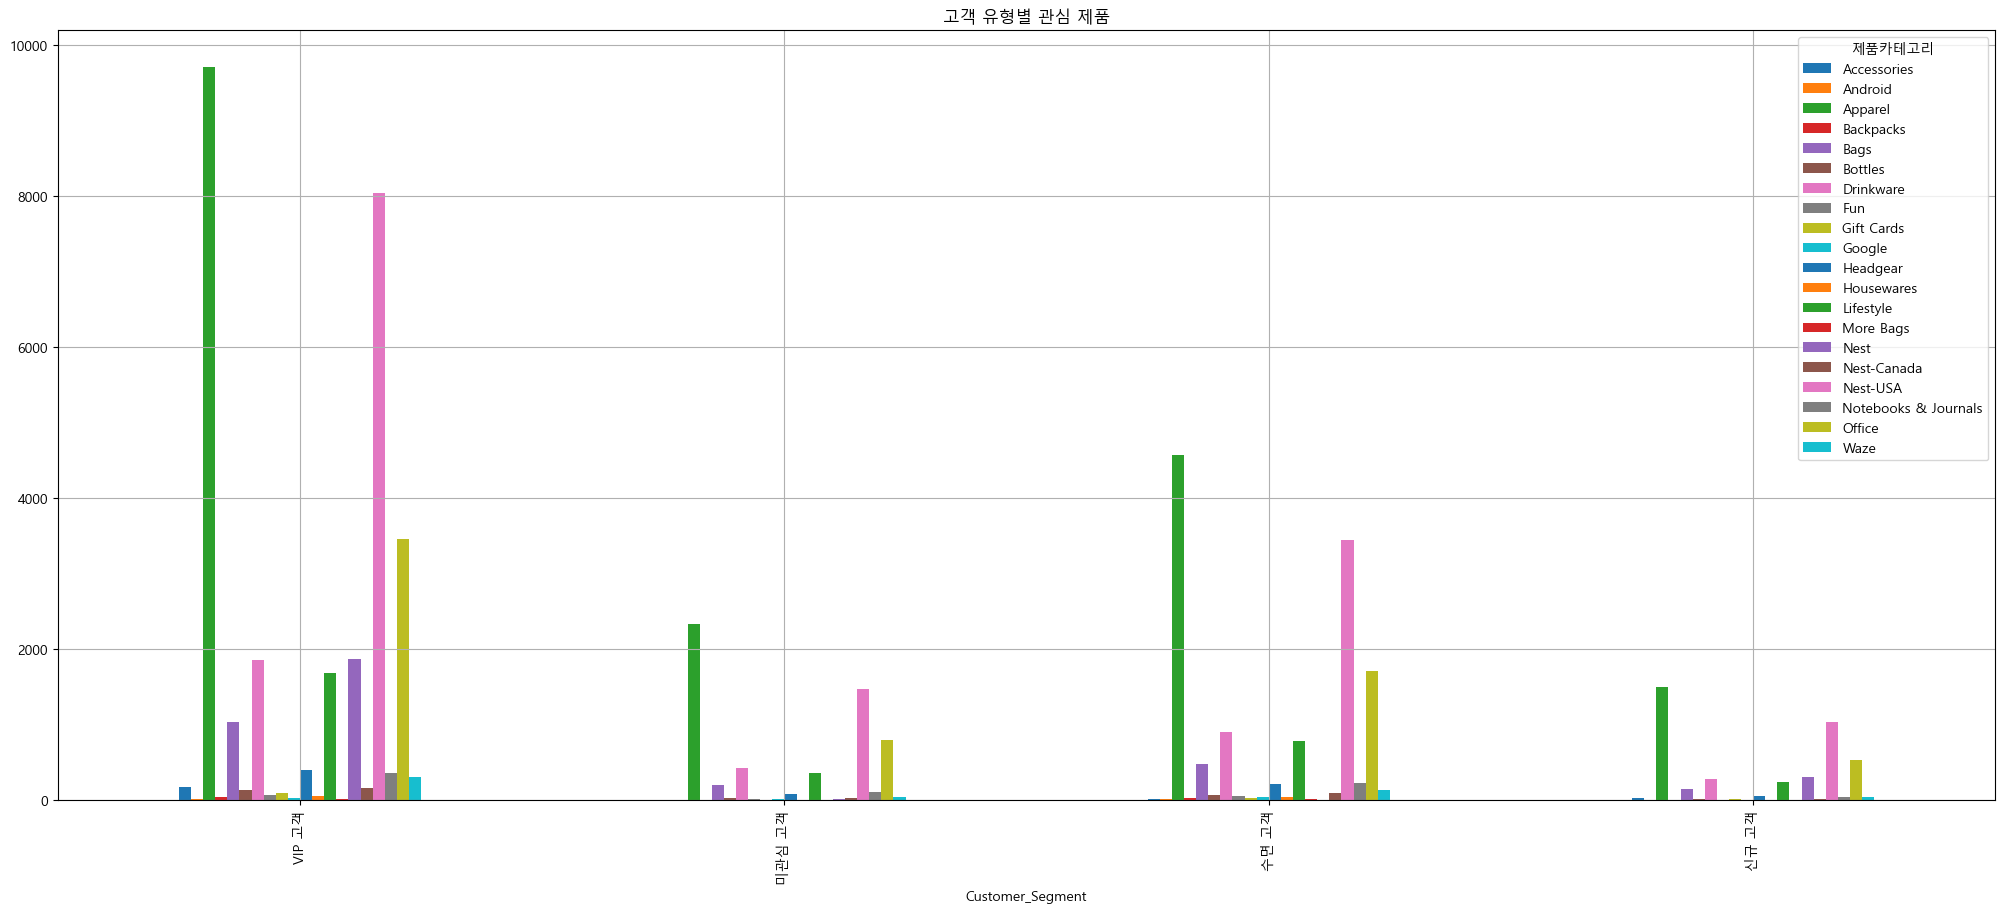

In [51]:
total_information_vip_plot = to_month(total_information, '거래날짜' )
total_information_vip_sleep_plot = pd.merge(total_information_vip_plot,rfm_kmean_merge, on = '고객ID' )
display(total_information_vip_sleep_plot)
total_information_vip_sleep_plot = pd.pivot_table(total_information_vip_sleep_plot,  index = 'Customer_Segment', columns = '제품카테고리', values = '수량', aggfunc='count')

total_information_vip_sleep_plot.plot(kind='bar')
plt.title('고객 유형별 관심 제품')
plt.grid()

## 수면 고객의 제품 카테고리별 거래금액

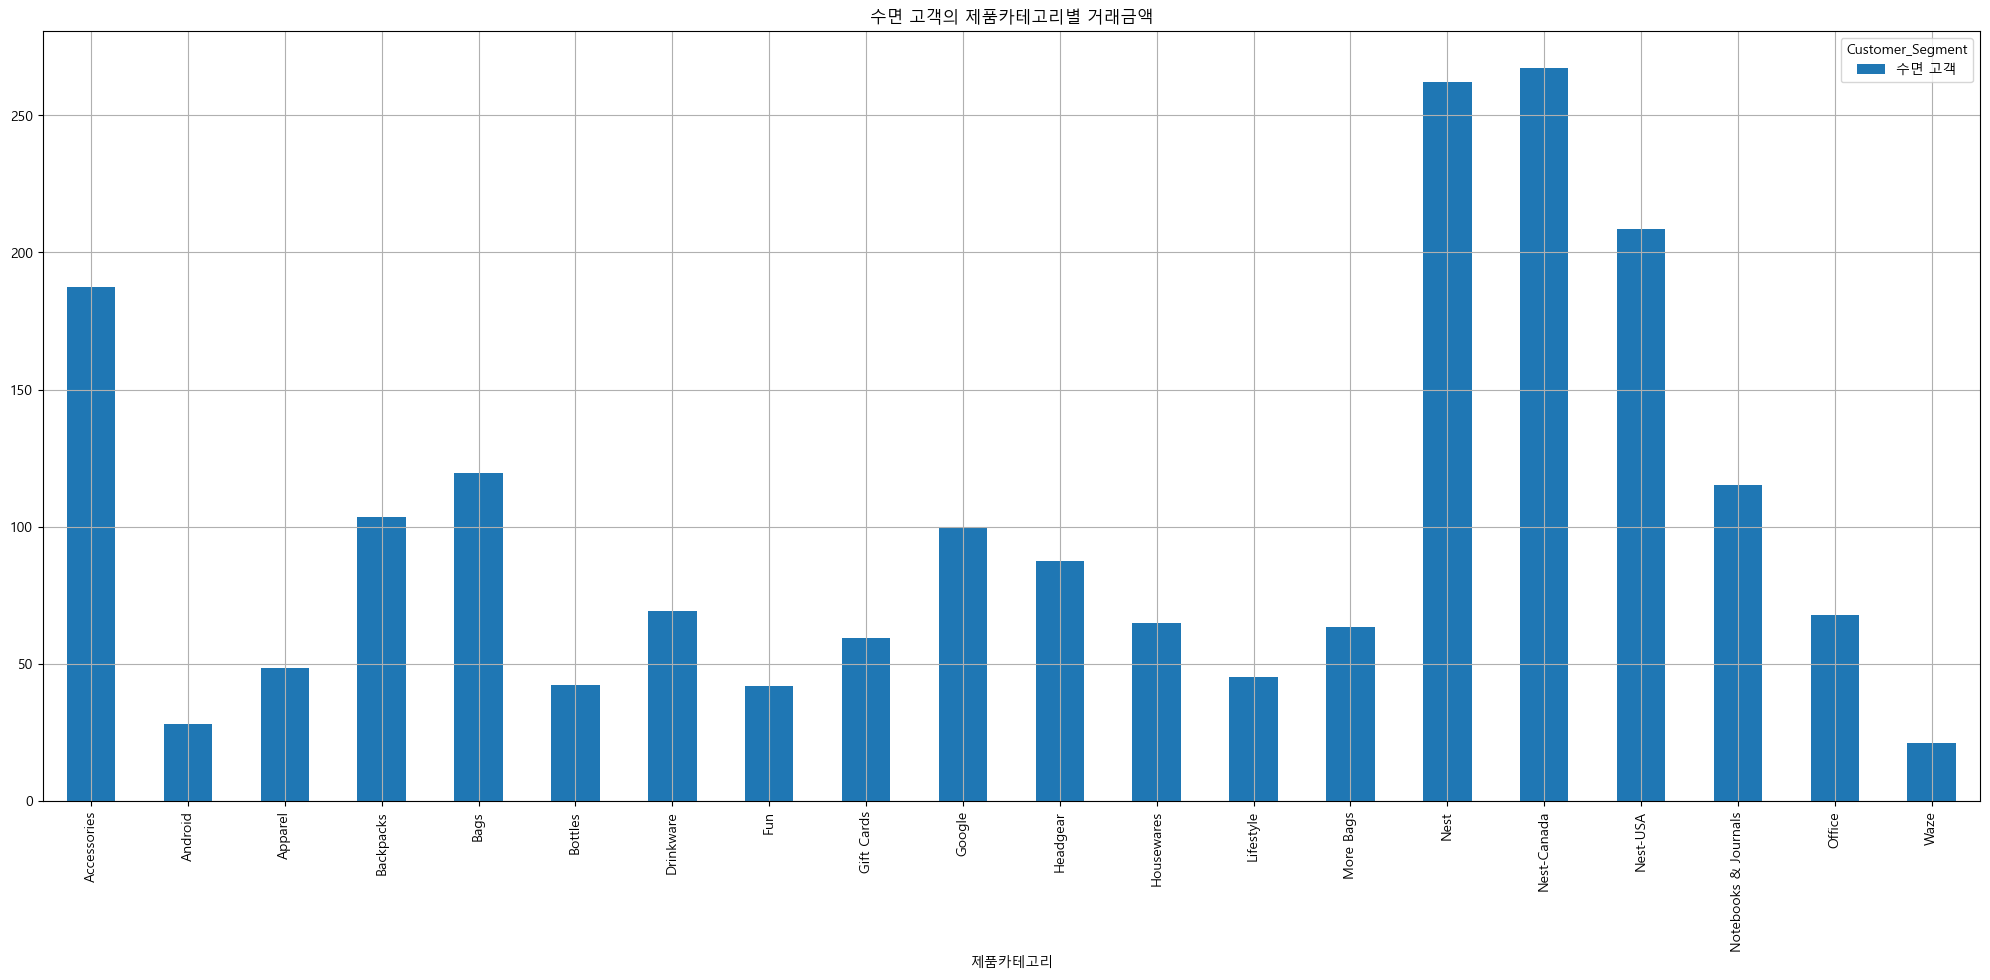

In [52]:
total_information_vip_plot = to_month(total_information, '거래날짜' )
total_information_vip_sleep_plot = pd.merge(total_information_vip_plot,rfm_kmean_merge, on = '고객ID' )

total_information_sleep_plot = total_information_vip_sleep_plot.loc[total_information_vip_sleep_plot['Customer_Segment']=='수면 고객']
pd.pivot_table(total_information_sleep_plot, columns = 'Customer_Segment', index = '제품카테고리', values = 'Total_Purchase_Amount', aggfunc='mean').plot(kind='bar')
plt.title('수면 고객의 제품카테고리별 거래금액')
plt.grid()

## 수면 고객의 카테고리별 거래량

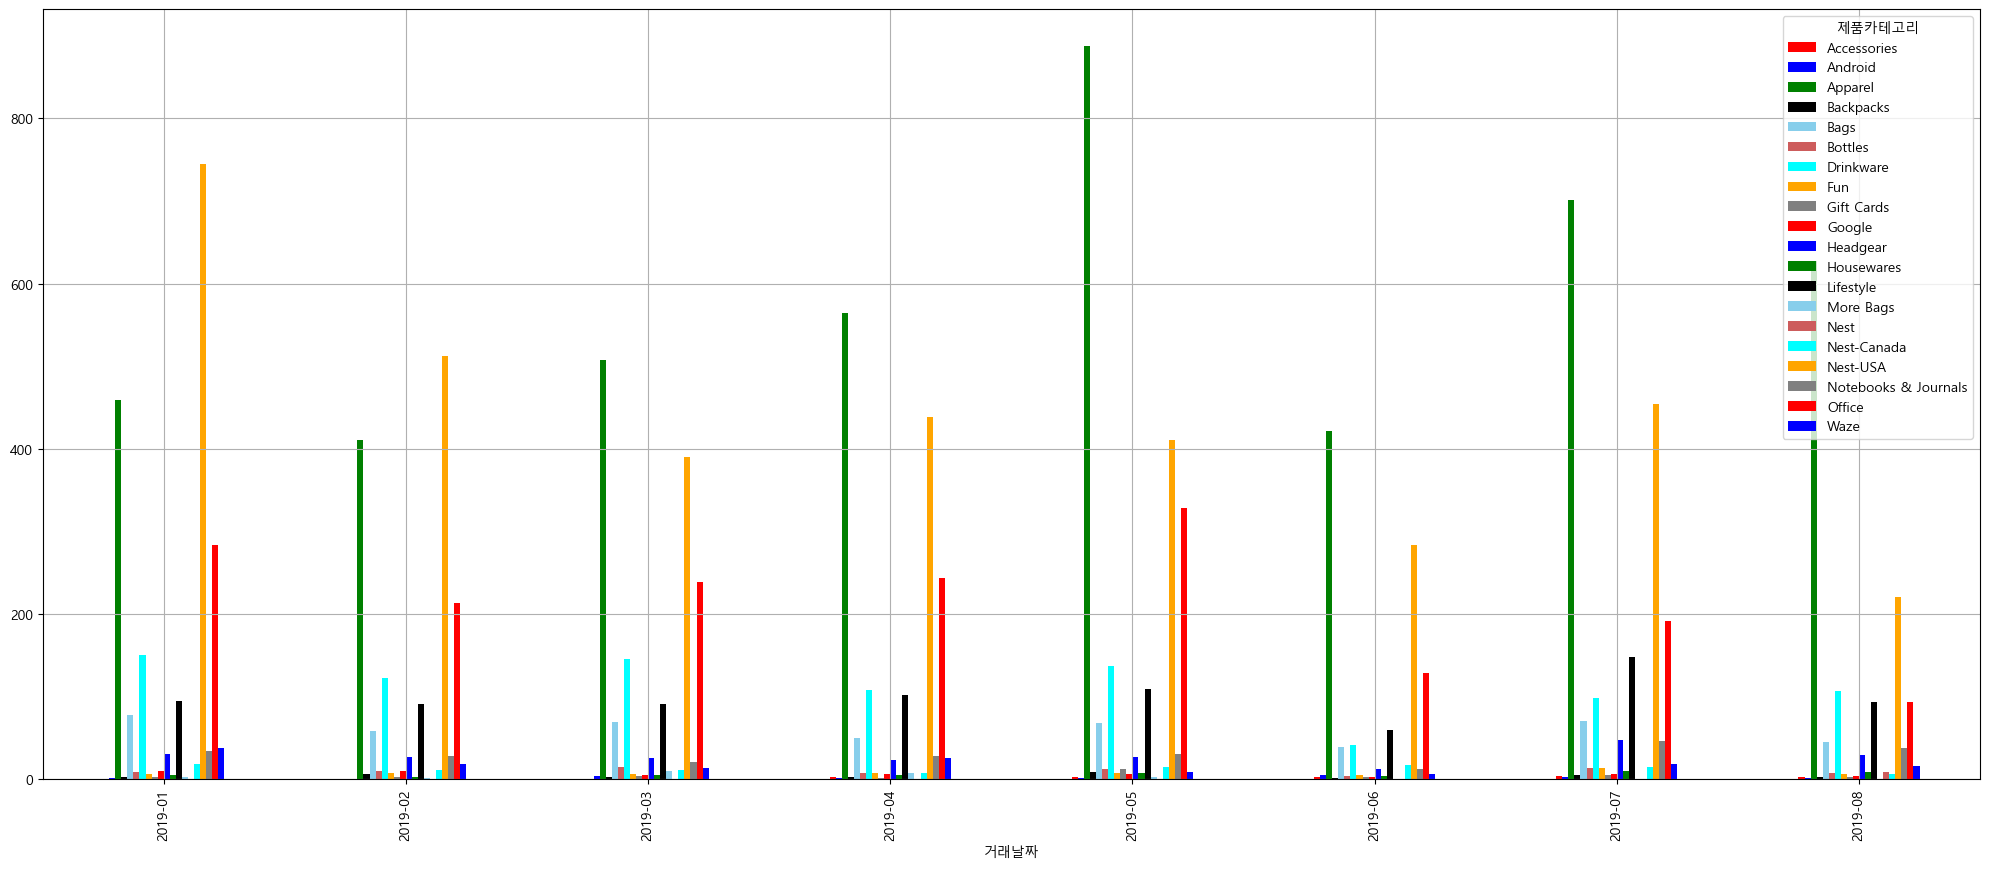

In [53]:
total_information_sleep_plot = to_month(total_information, '거래날짜' )
total_information_sleep_plot = pd.merge(total_information_vip_plot,rfm_kmean_merge, on = '고객ID' )
total_information_sleep_plot = total_information_sleep_plot.loc[total_information_sleep_plot['Customer_Segment']=='수면 고객']
total_information_sleep_plot
pd.pivot_table(total_information_sleep_plot, index = '거래날짜', 
               columns ='제품카테고리', values = '수량', aggfunc='count').fillna(0).plot(kind='bar',
                                                                                        color = ['Red', 'blue', 'Green', 'black', 'skyblue',
                                                                                                 'indianred', 'cyan', 'orange', 'grey'])
plt.grid()

## 수면 고객의 월별 카테고리별 거래금액 변화

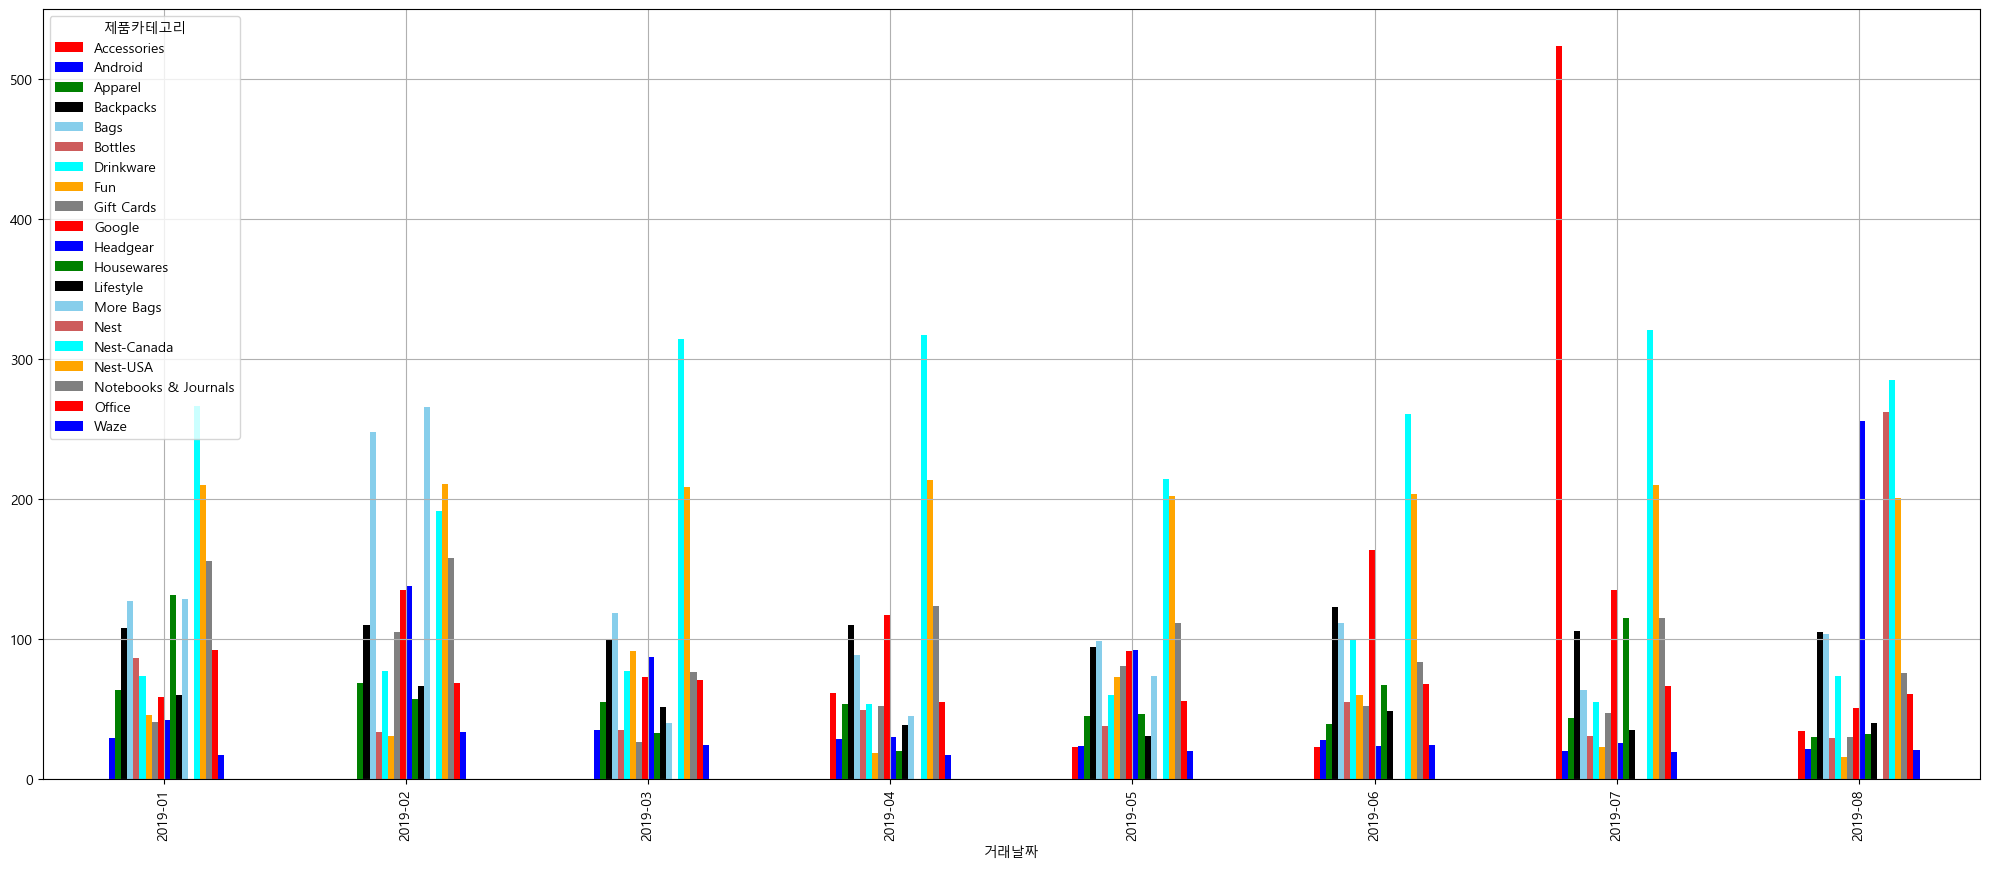

In [54]:
total_information_sleep_plot = to_month(total_information, '거래날짜' )
total_information_sleep_plot = pd.merge(total_information_vip_plot,rfm_kmean_merge, on = '고객ID' )
total_information_sleep_plot = total_information_sleep_plot.loc[total_information_sleep_plot['Customer_Segment']=='수면 고객']
total_information_sleep_plot
pd.pivot_table(total_information_sleep_plot, index = '거래날짜', columns ='제품카테고리', 
               values = 'Total_Purchase_Amount', aggfunc='mean').fillna(0).plot(kind='bar',
                                                                                         color = ['Red', 'blue', 'Green', 'black', 'skyblue',
                                                                                                  'indianred', 'cyan', 'orange', 'grey'])
plt.grid()

## 월별 카테고리별 판매수량 변화

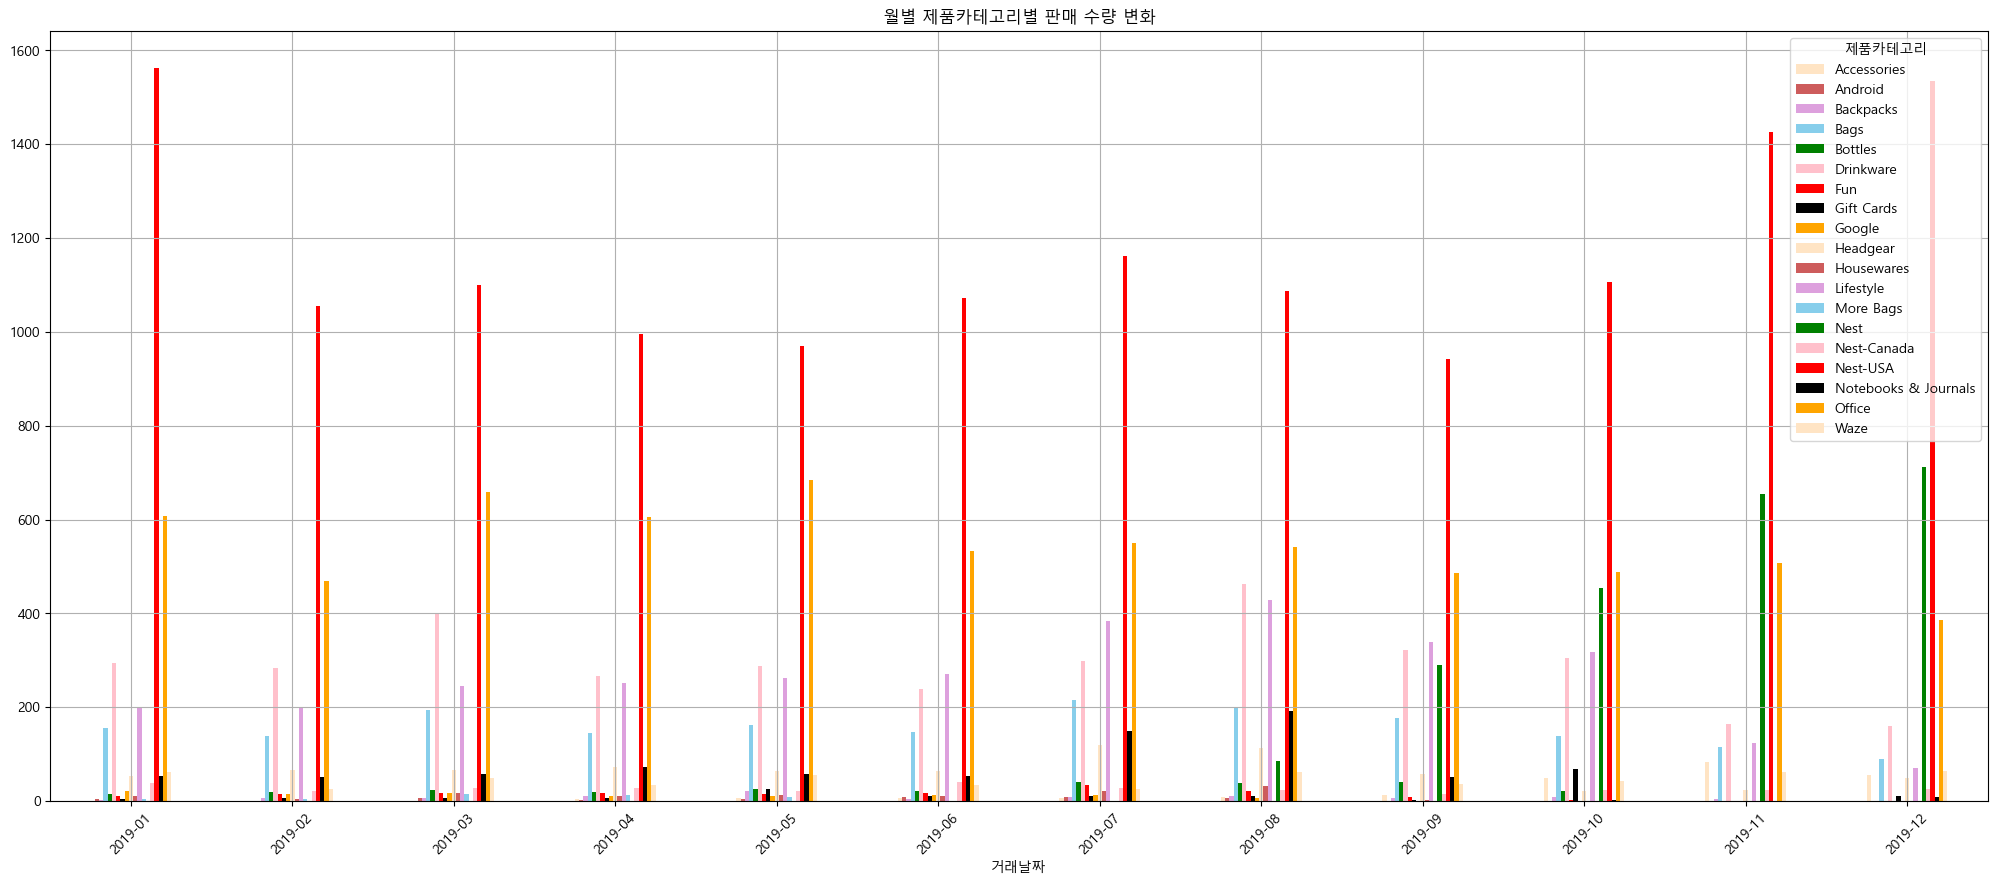

In [55]:
total_information_category = to_month(total_information, '거래날짜' )
total_information_category = pd.pivot_table(total_information_category, 
                                            index = '거래날짜', columns = '제품카테고리', values = '수량', aggfunc='count')
total_information_category.fillna(0, inplace=True)
total_information_category.drop('Apparel', axis=1, inplace=True)
total_information_category.plot(kind='bar', 
                                color = ['bisque', 'indianred', 'plum', 'skyblue', 'green', 'pink', 'red', 'black', 'orange'])

plt.title('월별 제품카테고리별 판매 수량 변화')
plt.grid()
plt.xticks(rotation=45)
plt.show()